# Assumptions:
1. Assume we know the number of board seats sought at the time of success prediction. For records with non-zero number of board seats sought, we assume missing in number of board seats gained mean zero. (Fact: number of board seats gained does not have zero in it.)
2. Assume all the information in X is available before announncement
3. For board seat control, define seat gained ratio as number of board seat gained over number of board seat sought. Define seat gained success as success if seat gained ratio is equal or greater than one, partial success if seat gained ratio is larger than zero but smaller than one, and fail if seat gained ratio is zero.
4. For total number of board seats being zero, we assume it's missing value.

In [1]:
import numpy as np
import pathlib as pa
import os
import pandas as pd
import tensorflow as tf
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

#Preprocessing
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
import sklearn.model_selection as ms
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
import category_encoders as ce
from sklearn.metrics import accuracy_score
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SMOTENC
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix

#Model
from xgboost import XGBClassifier
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neighbors import NearestCentroid
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import precision_score

import matplotlib.pyplot as plt


In [2]:
BASE_DIR = pa.Path(os.path.abspath('')).parent
DATA_DIR = BASE_DIR.joinpath('data')
WORK_DIR = BASE_DIR.joinpath('Model')

In [3]:
# read in data
all_data_csv = list(DATA_DIR.glob('**/*.csv'))
all_data_csv = [str(path) for path in all_data_csv]

all_data_txt = list(DATA_DIR.glob('**/*.txt'))
all_data_txt = [str(path) for path in all_data_txt]

Twitter_Count = pd.read_csv(all_data_csv[0]).iloc[:,1:]
BASE_DATA =pd.read_csv(all_data_csv[1])
BASE_DATA = pd.merge(BASE_DATA,Twitter_Count,how = 'outer')

# price_histroy = pd.read_csv(all_data_txt[0])

full_name = list(BASE_DATA.keys())

In [4]:
fig_path = BASE_DIR.joinpath('figs')
if not os.path.exists(str(fig_path)):
    os.mkdir(fig_path)

In [5]:
# Group governance_demand as in governance_demand prediction
BASE_DATA['governance_demand'][BASE_DATA['governance_demand'] == 'Board Seats (activist group)'] = 'Board'
BASE_DATA['governance_demand'][BASE_DATA['governance_demand'] == 'Other Governance Enhancements'] = 'Operations'
BASE_DATA['governance_demand'][BASE_DATA['governance_demand'] == 'Compensation Related Enhancements'] = 'Operations'
BASE_DATA['governance_demand'][BASE_DATA['governance_demand'] == 'Remove Director(s)'] = 'Officer_Demand'
BASE_DATA['governance_demand'][BASE_DATA['governance_demand'] == 'Social/Environmental/Political Issues'] = 'Operations'
BASE_DATA['governance_demand'][BASE_DATA['governance_demand'] == 'Remove Takeover Defenses'] = 'Operations'
BASE_DATA['governance_demand'][BASE_DATA['governance_demand'] == 'Add Independent Directors'] = 'Officer_Demand'
BASE_DATA['governance_demand'][BASE_DATA['governance_demand'] == 'Remove Officer(s)'] = 'Officer_Demand'


BASE_DATA['value_demand'][BASE_DATA['value_demand'] == 'Other Capital Structure Related, Increase Leverage, etc.'] = 'Operation'
BASE_DATA['value_demand'][BASE_DATA['value_demand'] == 'Breakup Company, Divest Assets/Divisions'] = 'Operation'
BASE_DATA['value_demand'][BASE_DATA['value_demand'] == 'Fund specific: Realize Net Asset Value/Open-End a Closed-End Fund'] = 'Operation'
BASE_DATA['value_demand'][BASE_DATA['value_demand'] == 'Fund specific: Change Investment Strategy'] = 'Operation'
BASE_DATA['value_demand'][BASE_DATA['value_demand'] == 'General Discussions/Underperformance'] = 'Operation'
BASE_DATA['value_demand'][BASE_DATA['value_demand'] == 'Review Strategic Alternatives'] = 'Operation'
BASE_DATA['value_demand'][BASE_DATA['value_demand'] == 'Block Acquisition/Agitate for Lower Price (Shareholder of Acquirer)'] = 'MA'
BASE_DATA['value_demand'][BASE_DATA['value_demand'] == 'Seek Sale/Merger/Liquidation'] = 'MA'
BASE_DATA['value_demand'][BASE_DATA['value_demand'] == 'Block Merger/Agitate for Higher Price (Shareholder of Target)'] = 'MA'
BASE_DATA['value_demand'][BASE_DATA['value_demand'] == 'Potential Acquisition (Friendly and Unfriendly)'] = 'MA'
BASE_DATA['value_demand'][BASE_DATA['value_demand'] == 'Return Cash via Dividends/Buybacks'] = 'Operation'
BASE_DATA['value_demand'][BASE_DATA['value_demand'] == 'Separate Real Estate/Create REIT'] = 'Operation'

#WATCH OUT!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
BASE_DATA = BASE_DATA[BASE_DATA['campaign_objective_primary'] != '13D Filer - No Publicly Disclosed Activism']
BASE_DATA = BASE_DATA[BASE_DATA['campaign_objective_primary'] != 'Remove Director(s), No Dissident Nominee to Fill Vacancy']
BASE_DATA = BASE_DATA[BASE_DATA['campaign_objective_primary'] != 'Remove Officer(s)']
BASE_DATA = BASE_DATA[BASE_DATA['campaign_objective_primary'] != 'Public Short Position/Bear Raid']
BASE_DATA = BASE_DATA[BASE_DATA['campaign_objective_primary'] != 'Vote For a Management Proposal/Support Management']


BASE_DATA['campaign_objective_primary'][BASE_DATA['campaign_objective_primary'] == 'Board Representation'] = 'Add_Directors'
BASE_DATA['campaign_objective_primary'][BASE_DATA['campaign_objective_primary'] == 'Board Control'] = 'Add_Directors'
BASE_DATA['campaign_objective_primary'][BASE_DATA['campaign_objective_primary'] == 'Maximize Shareholder Value'] = 'Generic_Objective'
BASE_DATA['campaign_objective_primary'][BASE_DATA['campaign_objective_primary'] == 'Enhance Corporate Governance'] = 'Generic_Objective'
BASE_DATA['campaign_objective_primary'][BASE_DATA['campaign_objective_primary'] == 'Hostile/Unsolicited Acquisition'] = 'Facilitate_MA'
BASE_DATA['campaign_objective_primary'][BASE_DATA['campaign_objective_primary'] == 'Vote/Activism Against a Merger'] = 'Block_MA'
BASE_DATA['campaign_objective_primary'][BASE_DATA['campaign_objective_primary'] == 'Vote For a Stockholder Proposal'] = 'Vote_For_Dissident'
BASE_DATA['campaign_objective_primary'][BASE_DATA['campaign_objective_primary'] == 'Vote Against a Management Proposal'] = 'Vote_For_Dissident'
BASE_DATA['campaign_objective_primary'][BASE_DATA['campaign_objective_primary'] == 'Support Dissident Group in Proxy Fight'] = 'Vote_For_Dissident'

type_adj = ['used_call_special_meeting_tactic',    
'used_hostile_offer_tactic',                                       
'used_lawsuit_tactic',                                             
'used_letter_to_stockholders_tactic',                              
'used_no_or_unknown_tactic',                                       
'used_nominate_slate_of_directors_tactic',                         
'used_propose_binding_proposal_tactic',                            
'used_propose_precatory_proposal_tactic',                          
'used_proxy_access_nomination_tactic',                             
'used_publicly_disclosed_letter_to_board_or_management_tactic',    
'used_take_action_by_written_consent_tactic',                      
'used_tender_offer_launched_tactic',                               
'used_tender_offer_stake_only_tactic',                             
'used_threaten_proxy_fight_tactic',                                
'used_unsolicited_offer_tactic',                                   
'used_withhold_vote_for_directors_tactic']                       
BASE_DATA[type_adj] = BASE_DATA[type_adj].astype('object')

BASE_DATA = BASE_DATA.reset_index(drop = True)


# Get rid of extreme value of ltm_eps_at_announcement
eps_col = BASE_DATA.columns == 'ltm_eps_at_announcement'
eps = BASE_DATA.loc[:,eps_col]
low = .05
high = .95
quant_df = eps.quantile([low, high])
eps = eps.apply(lambda x: x[(x.dtypes == 'float64') & (x>= quant_df.loc[low,x.name]) & (x <= quant_df.loc[high,x.name]) | (x.isnull())], axis=0)
BASE_DATA = pd.concat([BASE_DATA.loc[:,~eps_col], eps], join = 'inner',axis=1)
# Shape after deleting extreme value of ltm_eps_at_announcement
BASE_DATA.shape

# Hand picked X variables that do not leak information
X = ['campaign_objective_primary','value_demand','governance_demand','proxy_proposal',\
     'sector','total_number_of_board_seats',\
     'glass_lewis_support','iss_support','ownership_pecent_on_announcement','price_at_announcement',\
     'ltm_eps_at_announcement','earnings_yield_at_announcement','current_entity_detail','current_entity_status',\
     'public_before_or_after_campaign_announcement','poison_pill_in_force_prior_to_announcement',\
     'pre_18m_earnings_yield','pre_12m_earnings_yield','pre_6m_earnings_yield','pre_3m_earnings_yield',
     'pre_18m_total_return', 'pre_6m_residual_return','pre_12m_residual_return','pre_18m_residual_return',
     'used_call_special_meeting_tactic',
     'used_hostile_offer_tactic',
     'used_lawsuit_tactic',
     'used_letter_to_stockholders_tactic',
     'used_no_or_unknown_tactic',
     'used_nominate_slate_of_directors_tactic',
     'used_propose_binding_proposal_tactic',
     'used_propose_precatory_proposal_tactic',
     'used_proxy_access_nomination_tactic',
     'used_publicly_disclosed_letter_to_board_or_management_tactic',
     'used_take_action_by_written_consent_tactic',
     'used_tender_offer_launched_tactic',
     'used_tender_offer_stake_only_tactic',
     'used_threaten_proxy_fight_tactic',
     'used_unsolicited_offer_tactic', 
     'used_withhold_vote_for_directors_tactic',
     'tweet_count'
    ]

# Y1 as grouped proxy_campaign_winner_or_result 
Y = ['proxy_result']
# Y2 = ['success', 'partial success', 'fail'] if 
# board seat ratio >= 1, 0 < board seat ratio < 1, board seat ratio = 0
# board seat ratio = number of board seats gained / number of board seats sought
Y2 = ['seat_gained_success']


# Group categories with small counts
for col in ['proxy_proposal', 'current_entity_detail']:
    series_value_counts = BASE_DATA[col].value_counts()
    keys = dict(series_value_counts[series_value_counts<100]).keys()
    for key in keys:
        BASE_DATA[col][BASE_DATA[col] == key] = 'others'
        
BASE_DATA_ = BASE_DATA.copy()

# Define Y2
BASE_DATA_ = BASE_DATA_[BASE_DATA_['number_of_board_seats_sought'] != 0]
BASE_DATA_['seat_gained_ratio'] = BASE_DATA_['number_of_board_seats_gained'] / BASE_DATA_['number_of_board_seats_sought']
BASE_DATA_['seat_gained_ratio'][BASE_DATA_['seat_gained_ratio'] == np.nan] = 0
BASE_DATA_['seat_gained_ratio'] = BASE_DATA_['seat_gained_ratio'].fillna(0)

BASE_DATA_['seat_gained_success'] = np.nan
BASE_DATA_['seat_gained_success'][BASE_DATA_['seat_gained_ratio'] == 0] = 'Fail'
BASE_DATA_['seat_gained_success'][(BASE_DATA_['seat_gained_ratio'] > 0) & (BASE_DATA_['seat_gained_ratio'] < 1)] = 'Partial_success'
BASE_DATA_['seat_gained_success'][BASE_DATA_['seat_gained_ratio'] >= 1] = 'Success'

df_board_seats = BASE_DATA_[X + Y2].copy()

# Deine Binary Case
BASE_DATA__ = BASE_DATA_.copy()
BASE_DATA__ = BASE_DATA__[BASE_DATA__['number_of_board_seats_sought'] != 0]
BASE_DATA__['seat_gained_ratio'] = BASE_DATA__['number_of_board_seats_gained'] / BASE_DATA__['number_of_board_seats_sought']
BASE_DATA__['seat_gained_ratio'][BASE_DATA__['seat_gained_ratio'] == np.nan] = 0
BASE_DATA__['seat_gained_ratio'] = BASE_DATA__['seat_gained_ratio'].fillna(0)

BASE_DATA__['seat_gained_success'] = np.nan
BASE_DATA__['seat_gained_success'][BASE_DATA__['seat_gained_ratio'] == 0] = 'Fail'
BASE_DATA__['seat_gained_success'][BASE_DATA__['seat_gained_ratio'] > 0] = 'Success'

df_board_seats_binary = BASE_DATA__[X + Y2].copy()


# Show seat gained success composition
print('Board seat gain success composition:\n', 
      df_board_seats['seat_gained_success'].value_counts())

# Get whether variable is categorical
cate = BASE_DATA[X].dtypes == object
cate_name = BASE_DATA[X].select_dtypes(include=['object']).columns
num_name = BASE_DATA[X].select_dtypes(exclude=['object']).columns

cate_seats = df_board_seats[X].dtypes == object


# Fill missing proxy_campaign_winner_or_result as Missing
BASE_DATA['proxy_campaign_winner_or_result'] = BASE_DATA['proxy_campaign_winner_or_result'].fillna('Missing')

# Show proxy_campaign_winner_or_result composition
print('\nOriginal proxy_campaign_winner_or_result composition:\n', 
      BASE_DATA['proxy_campaign_winner_or_result'].value_counts())

# Group proxy_campaign_winner_or_result into three levels: Missing, Dissident, and Management
BASE_DATA['proxy_result'] = np.nan
BASE_DATA['proxy_result'][BASE_DATA['proxy_campaign_winner_or_result'] == 'Missing'] = 'Missing'
BASE_DATA['proxy_result'][BASE_DATA['proxy_campaign_winner_or_result'] == 'Settled/Concessions Made'] = 'Dissident'
BASE_DATA['proxy_result'][BASE_DATA['proxy_campaign_winner_or_result'] == 'Withdrawn'] = 'Management'
BASE_DATA['proxy_result'][BASE_DATA['proxy_campaign_winner_or_result'] == 'Dissident'] = 'Dissident'
BASE_DATA['proxy_result'][BASE_DATA['proxy_campaign_winner_or_result'] == 'Split'] = 'Dissident'
BASE_DATA['proxy_result'][BASE_DATA['proxy_campaign_winner_or_result'] == 'Management'] = 'Management'

# Drop any record with missing proxy_result, which are records with proxy_campaign_winner_or_result == Pending
# df = BASE_DATA[X + Y].copy()
df = BASE_DATA.dropna(how = 'any',subset=['proxy_result'])

# Show proxy_result composition after grouping
print('\nGrouped proxy_campaign_winner_or_result composition:\n', df['proxy_result'].value_counts())

# Get feature name after one-hot encoding
hot = OneHotEncoder(drop = 'first',sparse = False ,handle_unknown='error')
hot.fit_transform(df_board_seats[X].select_dtypes(include = 'object').replace(np.nan,'Missing'))
hot.get_feature_names()
combine_seat = list(num_name) + hot.get_feature_names(df_board_seats[X].select_dtypes(include = 'object').replace(np.nan,'Missing').columns).tolist()

# Get feature name after one-hot encoding
hot = OneHotEncoder(drop = 'first',sparse = False,handle_unknown='error')
hot.fit_transform(df[X].select_dtypes(include = 'object').replace(np.nan,'Missing'))
feature_name = hot.get_feature_names(df[X].select_dtypes(include = 'object').replace(np.nan,'Missing').columns)
combine_proxy = list(num_name) + feature_name.tolist()


# Get feature name after one-hot encoding
df2 = df[df['proxy_result'] != 'Missing']

hot = OneHotEncoder(drop = 'first', sparse = False,handle_unknown='error')
hot.fit_transform(df2[X].select_dtypes(include = 'object').replace(np.nan,'Missing'))
combine_proxy_complete = list(num_name) + hot.get_feature_names(df2[X].select_dtypes(include = 'object').replace(np.nan,'Missing').columns).tolist()



Board seat gain success composition:
 Fail               1036
Success             433
Partial_success     391
Name: seat_gained_success, dtype: int64

Original proxy_campaign_winner_or_result composition:
 Missing                     5168
Settled/Concessions Made     672
Management                   500
Withdrawn                    432
Dissident                    329
Split                         54
Pending                       39
Name: proxy_campaign_winner_or_result, dtype: int64

Grouped proxy_campaign_winner_or_result composition:
 Missing       5168
Dissident     1055
Management     932
Name: proxy_result, dtype: int64


## Proxy result
    Assume all the information in X is available before announncement
    


## Note:
We grouped proxy_campaign_winner_or_result into the following categories:
    - Missing
    - Dissident
        - Settled/Concessions Made
        - Dissident
        - Split (dissident's partial success, so also count as dissident)
    - Manamgent
        - Managment
        - Withdrawn
    - Delete Pending records

# Data preprocessing

### Utility

In [6]:
def balanced_subsample(x,y,subsample_size=1.0):

    class_xs = []
    min_elems = None

    for yi in np.unique(y):
        elems = x[(y == yi)]
        class_xs.append((yi, elems))
        if min_elems == None or elems.shape[0] < min_elems:
            min_elems = elems.shape[0]

    use_elems = min_elems
    if subsample_size < 1:
        use_elems = int(min_elems*subsample_size)

    xs = []
    ys = []

    for ci,this_xs in class_xs:
        if len(this_xs) > use_elems:
            np.random.shuffle(this_xs)

        x_ = this_xs[:use_elems]
        y_ = np.empty(use_elems)
        y_.fill(ci)

        xs.append(x_)
        ys.append(y_)

    xs = np.concatenate(xs)
    ys = np.concatenate(ys)

    return xs,ys


def produce_confusion_matrix(x_test,y_test,col,model):
    pred = model.predict(x_test)
    matrix = confusion_matrix(y_test, pred, labels=y_test[col].unique())
    # By definition a confusion matrix C is such that Cij is equal to the number of observations 
    # known to be in group i but predicted to be in group j.
    # Thus in binary classification, the count of true negatives is C0,0, false negatives is C1,0, 
    # true positives is C1,1 and false positives is C0,1.
    precision = [matrix[i,i] / sum(matrix[:,i]) for i in range(matrix.shape[1])]
    recall = [matrix[i,i] / sum(matrix[i,:]) for i in range(matrix.shape[1])]
    d1 = pd.DataFrame(precision, columns=['Precision'], index = y_test[col].unique())
    d2 = pd.DataFrame(recall, columns=['Recall'], index = y_test[col].unique())
    precision_recall = pd.concat([d1,d2], axis=1)
    return matrix, precision_recall
    

        
def cat_direction_assessment(col,model,x_train,combine,y = 'board_seat_gained_success'):
    temp = pd.DataFrame(x_train)
    temp.columns = combine
    temp[y] = pd.DataFrame({y:model.predict(temp)}).reset_index(drop = True)
    temp = temp[(temp[col] == 0.0) | (temp[col] == 1.0)]
    print(temp.groupby(col)[y].value_counts().to_frame())
    print('\n')

    temp = pd.DataFrame(x_train)
    temp.columns = combine
    temp[col] = 0
    temp[y] = pd.DataFrame({y:model.predict(temp)}).reset_index(drop = True)    
    print(temp.groupby(col)[y].value_counts().to_frame())
    print('\n')

    temp = pd.DataFrame(x_train)
    temp.columns = combine
    temp[col] = 1
    temp[y] = pd.DataFrame({'y':model.predict(temp)}).reset_index(drop = True)
    print(temp.groupby(col)[y].value_counts().to_frame())
    
    
def plot_confusion_matrix(y_true, y_pred,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=False):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools
    from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score
    
    cm = confusion_matrix(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
#     precision = precision_score(y_true, y_pred, pos_label="Operation")
#     recall = recall_score(y_true, y_pred, pos_label="Operation")

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(6, 4))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    plt.xticks([], [])
    plt.yticks([], [])

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('\n \nTrue label')
    plt.xlabel('\n Predicted label')
    plt.savefig(fig_path.joinpath('confusion_matrix_seat'),bbox_inches = "tight")
    plt.show()



def plot_feature_importance(classifier,df_board_seats,model_name,feature_name,use_coef = True):
    
    combine = feature_name
    # Get top 20 important features
    if use_coef:
        feature_importance_dict = dict(zip(combine, classifier.coef_[0]))
    else:
        feature_importance_dict = dict(zip(combine, classifier.feature_importances_))
    top_20_important = {k:v for k,v in sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)[:10]}
    
    if use_coef:
        least_20_important = {k:v for k,v in sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)[-10:]}
        name = [item for item in top_20_important] + [item for item in least_20_important]
        importance = [top_20_important[item] for item in top_20_important] + [least_20_important[item] for item in least_20_important]
    else:
        name = [item for item in top_20_important]
        importance = [top_20_important[item] for item in top_20_important]
    print(name)
    print(importance)
    # Plot top 10 important features
    if use_coef:
        _=plt.figure(figsize=(7,5))
        sns.set(style="whitegrid")
        _=sns.barplot(name,importance,palette="Blues_d")
        _=plt.xticks(rotation='vertical')
        _=plt.title('Top 10 Pos/Neg Coefficients for ' + model_name)
        _=plt.xlabel('Features')
        _=plt.ylabel('coefficient')
        _=plt.xticks(range(len(name)),name)
        plt.savefig(fig_path.joinpath('feture_importance_l1_logistic_Proxy_Result'),bbox_inches = "tight")
    else:
        _=plt.figure(figsize=(5,5))
        sns.set(style="whitegrid")
        _=sns.barplot(name,importance,palette="Blues_d")
        _=plt.xticks(rotation='vertical')
        _=plt.title('Top 10 Feature Importance for ' + model_name)
        _=plt.xlabel('Features')
        _=plt.ylabel('Importance')
        _=plt.xticks(range(len(name)),name)
        plt.savefig(fig_path.joinpath('feture_importance_random_forest_Board_Seat'),bbox_inches = "tight")
        
    return top_20_important

def inference(model,x_train,x_test,y_test,data_frame,feature_importance_plot_name,feature_name,use_coef = True, y = 'proxy_result',col = None,dir_inference = True):
    pred = model.predict(x_test)
    plot_confusion_matrix(y_test,pred,['a','b','c'])
    top_20_feature = plot_feature_importance(model,data_frame,feature_importance_plot_name,feature_name, use_coef = use_coef)
    if col != None and dir_inference != False:
        cat_direction_assessment(col,model,x_train,feature_name,y = y)

## Preprocessing_Pipeline

In [7]:
# SMOTE
sm = SMOTENC(random_state=42, categorical_features=cate)

# Impute missing numerical variable as -9999
pipeline_component = make_pipeline(StandardScaler(), SimpleImputer(missing_values = np.nan, strategy = 'constant',fill_value = -9999))

# Impute missing categorical variable as NA and do One-Hot Encoding
pipeline_component_cate = make_pipeline(SimpleImputer(missing_values = np.nan, strategy = 'constant',
                                                      fill_value = 'NA'),
                                          (OneHotEncoder(drop = 'first',sparse = False ,handle_unknown='error')))

# Combine numerical and categorical variables preprocessing
preprocess = make_column_transformer((pipeline_component,~cate),
                                     (pipeline_component_cate,cate))

# Perform preprocessing on data with missing y
x_preprocessed = preprocess.fit(df[X],df[Y]).transform(df[X])
x_preprocessed_seat = preprocess.fit(df_board_seats[X],df_board_seats[Y2]).transform(df_board_seats[X])
x_preprocessed_seat_binary = preprocess.fit(df_board_seats_binary[X],df_board_seats_binary[Y2]).transform(df_board_seats_binary[X])

# Perform preprocessing on data without missing y
x_preprocessed_complete = preprocess.fit(df2[X],df2[Y]).transform(df2[X])

# Perform train test split
x_train, x_test, y_train, y_test = train_test_split(x_preprocessed, df[Y], test_size = 0.2, random_state=0)
x_train_complete, x_test_complete, y_train_complete, y_test_complete = train_test_split(x_preprocessed_complete, 
                                                                                        df2[Y], test_size = 0.2, 
                                                                                        random_state=0)
x_train_seat, x_test_seat, y_train_seat, y_test_seat = train_test_split(x_preprocessed_seat, df_board_seats[Y2], test_size = 0.2, random_state=0)
x_train_seat_b, x_test_seat_b, y_train_seat_b, y_test_seat_b = train_test_split(x_preprocessed_seat_binary, df_board_seats_binary[Y2], test_size = 0.2, random_state=0)

# Print proxy_result composition before up-sampling
print('x_train, y_train shape before up-sampling:\n', x_train.shape, y_train.shape)
print('\nproxy_result composition before up-sampling:\n',y_train['proxy_result'].value_counts())
print('\nseat_gained_success composition before up-sampling:\n',y_train_seat['seat_gained_success'].value_counts())

from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
# Perform SMOTE up-sampling
# x_train, y_train = sm.fit_resample(x_train, y_train)
# x_train_complete, y_train_complete = sm.fit_resample(x_train_complete, y_train_complete)
# x_train_seat, y_train_seat = sm.fit_resample(x_train_seat, y_train_seat)

x_train, y_train = ros.fit_resample(x_train, y_train)
x_train_complete, y_train_complete = ros.fit_resample(x_train_complete, y_train_complete)
x_train_seat, y_train_seat = ros.fit_resample(x_train_seat, y_train_seat)
x_train_seat_b, y_train_seat_b = ros.fit_resample(x_train_seat_b, y_train_seat_b)

# Print proxy_result composition after up-sampling
print('\nx_train, y_train shape after up-sampling:\n',x_train.shape, y_train.shape)
unique, counts = np.unique(y_train, return_counts=True)
print('\nproxy_result composition after up-sampling:\n', dict(zip(unique, counts)))
unique, counts = np.unique(y_train_seat, return_counts=True)
print('\nseat_gained_success composition after up-sampling:\n', dict(zip(unique, counts)))
      

x_train, y_train shape before up-sampling:
 (5724, 78) (5724, 1)

proxy_result composition before up-sampling:
 Missing       4138
Dissident      843
Management     743
Name: proxy_result, dtype: int64

seat_gained_success composition before up-sampling:
 Fail               820
Success            337
Partial_success    331
Name: seat_gained_success, dtype: int64

x_train, y_train shape after up-sampling:
 (12414, 78) (12414,)

proxy_result composition after up-sampling:
 {'Dissident': 4138, 'Management': 4138, 'Missing': 4138}

seat_gained_success composition after up-sampling:
 {'Fail': 820, 'Partial_success': 820, 'Success': 820}


# Proxy_result

Missing       0.719776
Dissident     0.148148
Management    0.132075
Name: proxy_result, dtype: float64


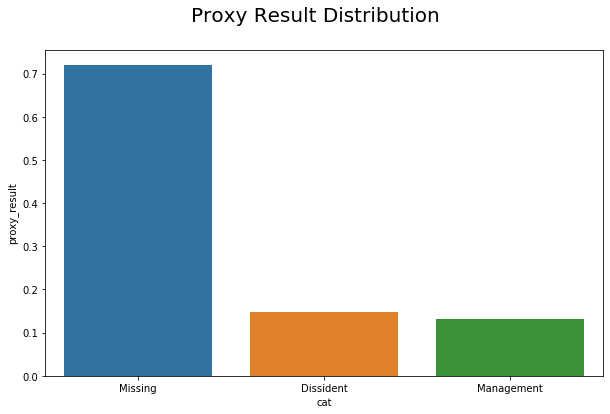

In [8]:
f, ax = plt.subplots(figsize=(10, 6))
y_dist = (y_test['proxy_result'].value_counts()/ y_test['proxy_result'].value_counts().sum()).to_frame()
y_dist['cat'] = y_dist.index
y_dist.reset_index(drop = True)
sns.barplot(x="cat", y="proxy_result",  data=y_dist,axes = ax)
f.suptitle('Proxy Result Distribution', fontsize=20)
# plt.xlabel('xlabel', fontsize=18)
# plt.ylabel('ylabel', fontsize=16)
# f.savefig('test.jpg')
print(y_test['proxy_result'].value_counts()/ y_test['proxy_result'].value_counts().sum())

Dissident     0.515075
Management    0.484925
Name: proxy_result, dtype: float64


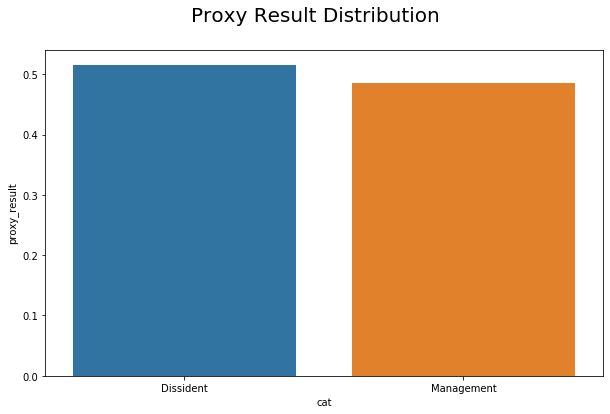

In [9]:
f, ax = plt.subplots(figsize=(10, 6))
y_dist = (y_test_complete['proxy_result'].value_counts()/ y_test_complete['proxy_result'].value_counts().sum()).to_frame()
y_dist['cat'] = y_dist.index
y_dist.reset_index(drop = True)
sns.barplot(x="cat", y="proxy_result",  data=y_dist,axes = ax)
f.suptitle('Proxy Result Distribution', fontsize=20)
# plt.xlabel('xlabel', fontsize=18)
# plt.ylabel('ylabel', fontsize=16)
# f.savefig('test.jpg')
print(y_test_complete['proxy_result'].value_counts()/ y_test_complete['proxy_result'].value_counts().sum())

## l1 penalty logistic regression

In [10]:
# Logistic regression with l1 norm
lg_l1 = LogisticRegression(penalty = 'l1',multi_class = 'auto')

# , solver = 'saga'
# Perform grid search
# param_grid = {'C': np.linspace(0.00000000000001, 2, 3)}
# param_grid = {'C': np.logspace(-4, 4, 10)}
param_grid = {'C': np.linspace(0.00000000000001, 2, 3),
             'solver': ['saga','liblinear']}

grid = GridSearchCV(lg_l1, param_grid, cv=2, scoring = 'precision_macro')
grid.fit(x_train, y_train)
lg_l1_best = grid.best_estimator_
print("The best parameter for Logistic is {}".format(grid.best_params_))
print("Training precision for Logistic Regression is {}".format(round(grid.score(x_train, y_train),5)))
print("Testing precision for Logistic Regression is {}".format(round(grid.score(x_test, y_test),5)))

The best parameter for Logistic is {'C': 2.0, 'solver': 'liblinear'}
Training precision for Logistic Regression is 0.76
Testing precision for Logistic Regression is 0.705


In [11]:
conf, pre_recall = produce_confusion_matrix(x_test, y_test, 'proxy_result', grid) 
pre_recall

,Precision,Recall
Dissident,0.582160,0.584906
Missing,0.989247,0.982524
Management,0.543590,0.560847


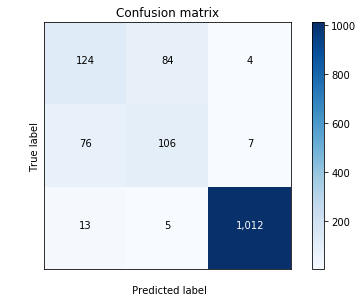

['used_tender_offer_stake_only_tactic_1', 'glass_lewis_support_Split', 'used_nominate_slate_of_directors_tactic_1', 'used_take_action_by_written_consent_tactic_1', 'current_entity_detail_Mutual Fd-Closed End', 'proxy_proposal_others', 'poison_pill_in_force_prior_to_announcement_Yes', 'current_entity_detail_Public', 'current_entity_detail_others', 'governance_demand_Missing', 'sector_Communications', 'iss_support_Split', 'campaign_objective_primary_Block_MA', 'iss_support_Management', 'sector_Industrial Services', 'used_no_or_unknown_tactic_1', 'sector_Missing', 'campaign_objective_primary_Facilitate_MA', 'campaign_objective_primary_Generic_Objective', 'used_threaten_proxy_fight_tactic_1']
[1.3082179464029378, 1.2093332117629432, 0.8894595143496902, 0.6858633225251785, 0.6733743306184914, 0.6440139691457445, 0.5265834514320527, 0.34200395862329125, 0.25115420276592665, 0.23681287496283526, -0.9226673992816, -1.0611608166413584, -1.1398975384921464, -1.3355596465024238, -1.34509570040400

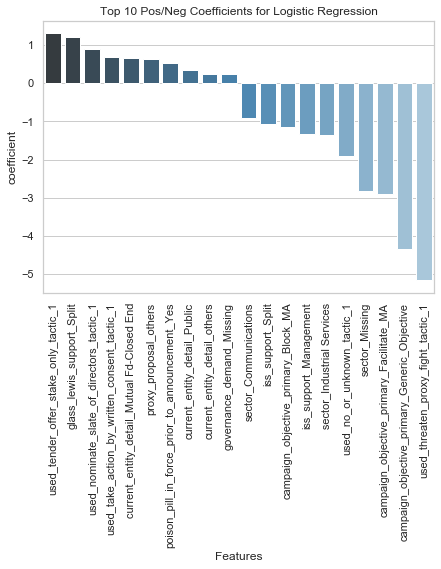

In [12]:
inference(lg_l1_best,x_train,x_test,y_test,df,'Logistic Regression',combine_proxy,use_coef = True, y = 'proxy_result',col = 'used_threaten_proxy_fight_tactic_1')


## Complete case

In [13]:
# Logistic regression
lg_l1 = LogisticRegression(penalty = 'l1',multi_class = 'auto')

# Perform grid search
# param_grid = {'C': np.linspace(0.00000000000001, 2, 3)}
param_grid = {'C': np.logspace(-4, 4, 10)}
grid = GridSearchCV(lg_l1, param_grid, cv=2)
grid.fit(x_train_complete, y_train_complete)
lg_l1_complete_best = grid.best_estimator_
print("The best parameter for Logistic is {}".format(grid.best_params_))
print("Training balanced accuracy for Logistic Regression is {}".format(round(grid.score(x_train_complete, y_train_complete),5)))
print("Testing balanced accuracy for Logistic Regression is {}".format(round(grid.score(x_test_complete, y_test_complete),5)))

The best parameter for Logistic is {'C': 2.782559402207126}
Training balanced accuracy for Logistic Regression is 0.64882
Testing balanced accuracy for Logistic Regression is 0.61307


In [14]:
# confusion_matrix with order: ['Management', 'Dissident']
conf, pre_recall = produce_confusion_matrix(x_test_complete, y_test_complete, 'proxy_result', lg_l1_complete_best) 
pre_recall

,Precision,Recall
Management,0.601036,0.601036
Dissident,0.624390,0.624390


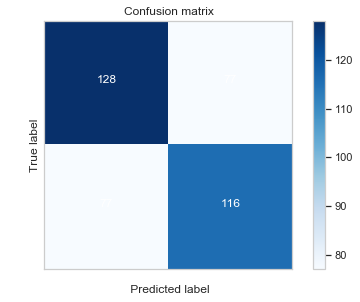

['iss_support_Management', 'campaign_objective_primary_Generic_Objective', 'iss_support_Missing', 'glass_lewis_support_Management', 'used_proxy_access_nomination_tactic_1', 'iss_support_Split', 'sector_Health Services', 'used_unsolicited_offer_tactic_1', 'sector_Transportation', 'campaign_objective_primary_Block_MA', 'poison_pill_in_force_prior_to_announcement_Yes', 'current_entity_detail_Subsidiary', 'value_demand_Operation', 'sector_Process Industries', 'sector_Consumer Non-Durables', 'used_tender_offer_stake_only_tactic_1', 'current_entity_detail_Holding Company', 'current_entity_detail_Mutual Fd-Closed End', 'sector_Distribution Services', 'campaign_objective_primary_Facilitate_MA']
[1.296736912101737, 1.1584666536704193, 0.9717422525223971, 0.83256965780955, 0.7214350000416377, 0.7194586085215697, 0.675696635561024, 0.5274502840092372, 0.49577399710494063, 0.487038672756997, -0.37962349296263564, -0.4154130733302482, -0.4205193228803522, -0.42114267677281925, -0.4255508676681347, 

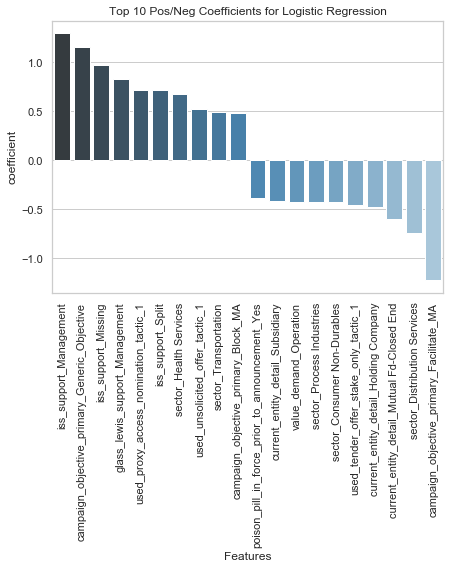

In [15]:
inference(lg_l1_complete_best,x_train_complete,x_test_complete,y_test_complete,df,'Logistic Regression',combine_proxy_complete,use_coef = True, y = 'proxy_result',col = 'sector_Distribution Services')


## l2 penalty logistic regression

In [16]:
# Logistic regression with l2 norm
lg_l2 = LogisticRegression(penalty = 'l2',multi_class = 'auto')

param_grid = {'C': np.logspace(-4, 4, 10),
             'solver': ['newton-cg', 'lbfgs', 'sag', 'saga']}

grid = GridSearchCV(lg_l2, param_grid, cv=2, scoring = 'precision_macro')
grid.fit(x_train, y_train)
lg_l2_best = grid.best_estimator_

print("The best parameter for Logistic is {}".format(grid.best_params_))
print("Training precision for Logistic Regression is {}".format(round(grid.score(x_train, y_train),5)))
print("Testing precision for Logistic Regression is {}".format(round(grid.score(x_test, y_test),5)))

The best parameter for Logistic is {'C': 10000.0, 'solver': 'newton-cg'}
Training precision for Logistic Regression is 0.76189
Testing precision for Logistic Regression is 0.70727


In [17]:
conf, pre_recall = produce_confusion_matrix(x_test, y_test, 'proxy_result', grid) 
pre_recall

,Precision,Recall
Dissident,0.583710,0.608491
Missing,0.987292,0.980583
Management,0.550802,0.544974


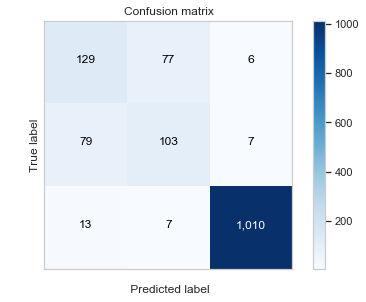

['used_call_special_meeting_tactic_1', 'used_take_action_by_written_consent_tactic_1', 'used_nominate_slate_of_directors_tactic_1', 'proxy_proposal_others', 'glass_lewis_support_Split', 'poison_pill_in_force_prior_to_announcement_Yes', 'used_tender_offer_stake_only_tactic_1', 'total_number_of_board_seats', 'current_entity_detail_others', 'used_hostile_offer_tactic_1', 'used_unsolicited_offer_tactic_1', 'sector_Missing', 'iss_support_Split', 'sector_Transportation', 'iss_support_Management', 'sector_Communications', 'sector_Industrial Services', 'used_threaten_proxy_fight_tactic_1', 'proxy_proposal_Missing', 'campaign_objective_primary_Generic_Objective']
[1.2986913451299646, 1.2618512393389012, 1.2254781055734962, 1.0223029506449681, 0.743141751007002, 0.7206392173352762, 0.681462524035702, 0.6295929414405423, 0.4750314152684278, 0.44548275043115443, -0.5231209429957132, -0.5403670385776876, -0.5567004111534724, -0.6293939166734991, -0.6687967068408471, -0.6815462241036794, -1.06298353

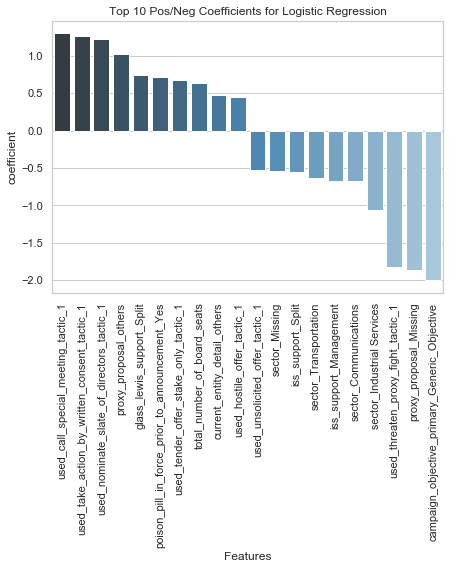

In [18]:
inference(lg_l2_best,x_train,x_test,y_test,df,'Logistic Regression',combine_proxy,use_coef = True, y = 'proxy_result',col = 'proxy_proposal_others')


## Complete case

In [19]:
# Logistic regression with l2 norm
lg_l2 = LogisticRegression(penalty = 'l2',multi_class = 'auto')

# grid search
# param_grid = {'C': np.linspace(0.00000000000001, 2, 3)}
param_grid = {'C': np.logspace(-4, 4, 10),
             'solver': ['newton-cg', 'lbfgs', 'sag', 'saga']}
grid = GridSearchCV(lg_l2, param_grid, cv=2)
grid.fit(x_train_complete, y_train_complete)

lg_l2_best_complete = grid.best_estimator_

print("The best parameter for Logistic is {}".format(grid.best_params_))
print("Training accuracy for Logistic Regression is {}".format(round(grid.score(x_train_complete, y_train_complete),5)))
print("Testing accuracy for Logistic Regression is {}".format(round(grid.score(x_test_complete, y_test_complete),5)))

The best parameter for Logistic is {'C': 2.782559402207126, 'solver': 'newton-cg'}
Training accuracy for Logistic Regression is 0.65059
Testing accuracy for Logistic Regression is 0.61558


In [20]:
conf, pre_recall = produce_confusion_matrix(x_test_complete, y_test_complete, 'proxy_result', grid) 
pre_recall

,Precision,Recall
Management,0.604167,0.601036
Dissident,0.626214,0.629268


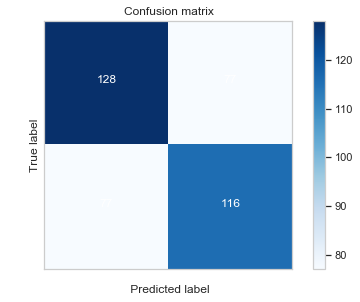

['iss_support_Management', 'campaign_objective_primary_Generic_Objective', 'iss_support_Missing', 'glass_lewis_support_Management', 'used_proxy_access_nomination_tactic_1', 'iss_support_Split', 'sector_Health Services', 'sector_Transportation', 'campaign_objective_primary_Block_MA', 'used_nominate_slate_of_directors_tactic_1', 'sector_Process Industries', 'poison_pill_in_force_prior_to_announcement_Yes', 'value_demand_Operation', 'current_entity_detail_Subsidiary', 'current_entity_detail_Holding Company', 'used_tender_offer_stake_only_tactic_1', 'current_entity_detail_Mutual Fd-Closed End', 'sector_Distribution Services', 'current_entity_detail_Public', 'campaign_objective_primary_Facilitate_MA']
[1.3005133984867845, 1.1326766889722732, 0.9740461217727883, 0.8530691949648523, 0.8050429585505383, 0.7843496865751199, 0.7831704014490555, 0.6201195088040108, 0.5807596653151259, 0.5691573329959123, -0.35316631651027935, -0.38056375203925896, -0.4197243026119303, -0.419933280817768, -0.49731

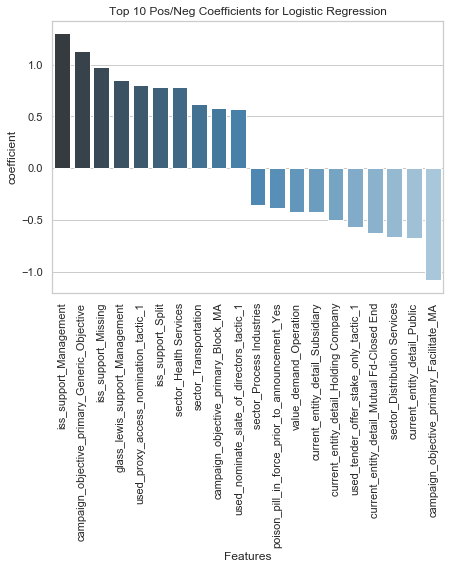

In [21]:
pred = lg_l1_complete_best.predict(x_test_complete)
plot_confusion_matrix(y_test_complete,pred,['a','b','c'])
top_20_feature = plot_feature_importance(lg_l2_best_complete,df,'Logistic Regression',combine_proxy_complete, use_coef = True)
cat_direction_assessment('used_nominate_slate_of_directors_tactic_1',lg_l2_best_complete,x_train_complete,combine_proxy_complete,y = 'proxy_result')

## Random Forest

In [22]:
# rf = RandomForestClassifier()
# param_grid = {'n_estimators': np.linspace(10, 500, 3).astype('int'),
#               'max_depth':np.linspace(10, 500, 3).astype('int'),
#               'min_samples_split':np.linspace(2, 50, 3).astype('int'),
#               'min_samples_leaf':np.linspace(1, 50, 3).astype('int'),
#               'bootstrap': [True, False],
#               'max_features': ['auto', 'sqrt'],
#              }

# grid = GridSearchCV(rf, param_grid, cv=2, scoring = 'precision_macro')
# grid.fit(x_train, y_train)
# print("The best parameter for Logistic is {}".format(grid.best_params_))
# print("Training precision for Random Forest is {}".format(round(precision_score(y_train, grid.predict(x_train),average='macro'),5)))
# print("Testing precision for Random Forest is {}".format(round(precision_score(y_test, grid.predict(x_test),average='macro'),5)))

### Note:
    Since training balanced accuracy is much higher than the testing one, we think the model with best paramters from grid search is overfitting. The following model prevents overfitting.

In [23]:
rf2 = RandomForestClassifier(bootstrap = False, 
                       max_depth = 4,
                       max_features = 'auto', 
                       min_samples_leaf = 10, 
                       min_samples_split = 10,
                       n_estimators = 100)
rf2.fit(x_train, y_train)


RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
                       max_depth=4, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [24]:
from sklearn.metrics import precision_score
print("Training precision for Random Forest is {}".format(round(precision_score(y_train, rf2.predict(x_train),average='macro'),5)))
print("Testing precision for Random Forest is {}".format(round(precision_score(y_test, rf2.predict(x_test),average='macro'),5)))

Training precision for Random Forest is 0.76744
Testing precision for Random Forest is 0.68713


In [25]:
conf, pre_recall = produce_confusion_matrix(x_test, y_test, 'proxy_result', rf2) 
pre_recall

,Precision,Recall
Dissident,0.572687,0.613208
Missing,0.968691,0.991262
Management,0.520000,0.412698


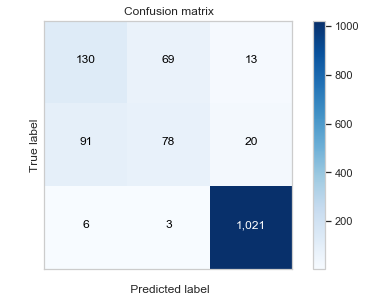

['used_nominate_slate_of_directors_tactic_1', 'total_number_of_board_seats', 'proxy_proposal_Missing', 'campaign_objective_primary_Generic_Objective', 'used_no_or_unknown_tactic_1', 'governance_demand_Missing', 'used_letter_to_stockholders_tactic_1', 'used_call_special_meeting_tactic_1', 'campaign_objective_primary_Vote_For_Dissident', 'used_threaten_proxy_fight_tactic_1']
[0.21339613685009776, 0.1758378455887737, 0.15871185822457484, 0.09615351106198304, 0.07092870340824746, 0.06680077275040675, 0.027529817398018425, 0.01933526830170285, 0.01848263263313795, 0.015869538415936163]
                                     proxy_result
iss_support_Management proxy_result              
0.0                    Missing               4464
                       Dissident             4369
                       Management            2489
1.0                    Management             781
                       Dissident              278
                       Missing                 33


          

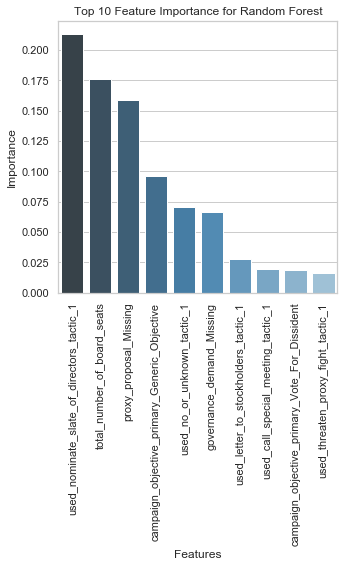

In [26]:
inference(rf2,x_train,x_test,y_test,df,'Random Forest',combine_proxy,use_coef = False, y = 'proxy_result',col = 'iss_support_Management')


In [27]:
rf2 = RandomForestClassifier(bootstrap = False, 
                       max_depth = 4,
                       max_features = 'auto', 
                       min_samples_leaf = 10, 
                       min_samples_split = 10,
                       n_estimators = 100)
rf2.fit(x_train_complete, y_train_complete)


RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
                       max_depth=4, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [28]:
from sklearn.metrics import precision_score
print("Training precision for Random Forest is {}".format(round(precision_score(y_train_complete, rf2.predict(x_train_complete),average='macro'),5)))
print("Testing precision for Random Forest is {}".format(round(precision_score(y_test_complete, rf2.predict(x_test_complete),average='macro'),5)))

Training precision for Random Forest is 0.6933
Testing precision for Random Forest is 0.61527


In [29]:
conf, pre_recall = produce_confusion_matrix(x_test_complete, y_test_complete, 'proxy_result', rf2) 
pre_recall

,Precision,Recall
Management,0.612360,0.564767
Dissident,0.618182,0.663415


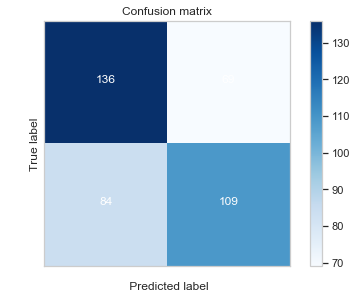

['ownership_pecent_on_announcement', 'iss_support_Management', 'pre_6m_earnings_yield', 'price_at_announcement', 'pre_12m_earnings_yield', 'used_unsolicited_offer_tactic_1', 'glass_lewis_support_Management', 'ltm_eps_at_announcement', 'sector_Finance', 'pre_6m_residual_return']
[0.2414697774520816, 0.06688225122556085, 0.04581179665943662, 0.045787879521067214, 0.04537670483210877, 0.03923796513460179, 0.03687500335403032, 0.03521001126692899, 0.03494410284147218, 0.03186818168434428]
                                     proxy_result
iss_support_Management proxy_result              
0.0                    Dissident              909
                       Management             587
1.0                    Management             152
                       Dissident               52


                                     proxy_result
iss_support_Management proxy_result              
0                      Dissident             1056
                       Management             644


      

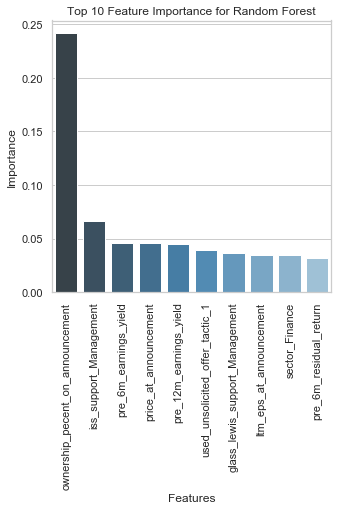

In [30]:
inference(rf2,x_train_complete,x_test_complete,y_test_complete,df,'Random Forest',combine_proxy_complete,use_coef = False, y = 'proxy_result',col = 'iss_support_Management')


## Xgboost

In [31]:
xgb = XGBClassifier(silent=False, 
                      scale_pos_weight=1,
                      learning_rate=0.01,  
                      colsample_bytree = 0.3,
                      subsample = 0.8,
                      n_estimators=500, 
                      reg_alpha = 0.3,
                      max_depth=3, 
                      gamma=10)

xgb.fit(x_train, y_train)
print("Training precision for xgboost is {}".format(round(precision_score(y_train, xgb.predict(x_train),average='macro'),5)))
print("Testing precision for xgboost is {}".format(round(precision_score(y_test, xgb.predict(x_test),average='macro'),5)))

Training precision for xgboost is 0.77967
Testing precision for xgboost is 0.69781


In [32]:
conf, pre_recall = produce_confusion_matrix(x_test, y_test, 'proxy_result', xgb) 
pre_recall

,Precision,Recall
Dissident,0.580087,0.632075
Missing,0.987342,0.984466
Management,0.526012,0.481481


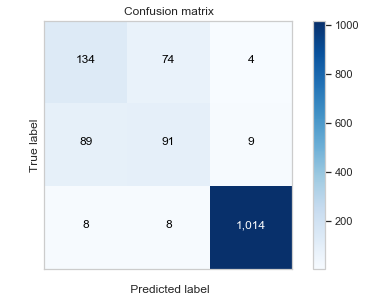

['used_nominate_slate_of_directors_tactic_1', 'total_number_of_board_seats', 'proxy_proposal_Missing', 'governance_demand_Missing', 'campaign_objective_primary_Generic_Objective', 'proxy_proposal_others', 'used_no_or_unknown_tactic_1', 'campaign_objective_primary_Vote_For_Dissident', 'used_call_special_meeting_tactic_1', 'used_letter_to_stockholders_tactic_1']
[0.1292723, 0.12596066, 0.086864114, 0.049435, 0.04297439, 0.02813379, 0.027285244, 0.023060352, 0.021259516, 0.021210415]


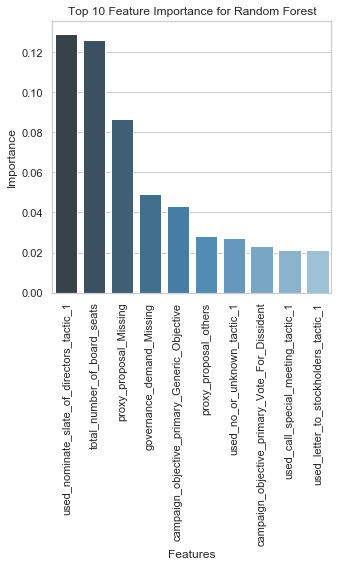

In [33]:
inference(xgb,x_train,x_test,y_test,df,'Random Forest',combine_proxy,use_coef = False, y = 'proxy_result',col = 'iss_support_Management',dir_inference = False)


Training precision for xgboost is 0.64117
Testing precision for xgboost is 0.60791
            Precision    Recall
Management   0.606936  0.544041
Dissident    0.608889  0.668293


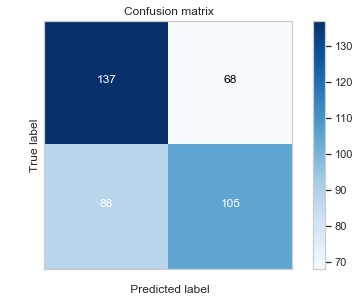

['ownership_pecent_on_announcement', 'iss_support_Missing', 'glass_lewis_support_Missing', 'pre_18m_earnings_yield', 'used_unsolicited_offer_tactic_1', 'pre_18m_residual_return', 'governance_demand_Missing', 'iss_support_Management', 'sector_Finance', 'used_publicly_disclosed_letter_to_board_or_management_tactic_1']
[0.07155625, 0.04314154, 0.038971968, 0.036786236, 0.034483433, 0.034304697, 0.03420549, 0.03300472, 0.032911498, 0.03267623]


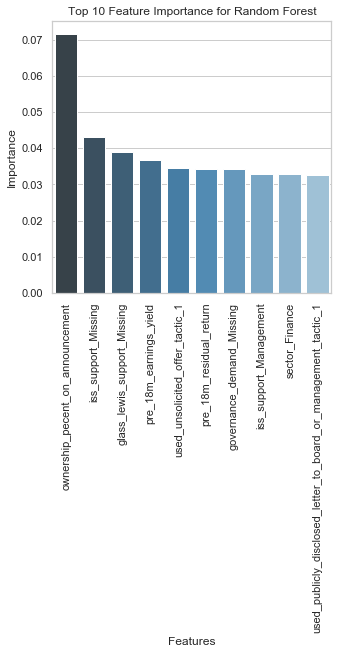

In [34]:
xgb = XGBClassifier(silent=False, 
                      scale_pos_weight=1,
                      learning_rate=0.01,  
                      colsample_bytree = 0.3,
                      subsample = 0.8,
                      n_estimators=500, 
                      reg_alpha = 0.3,
                      max_depth=3, 
                      gamma=10)

xgb.fit(x_train_complete, y_train_complete)
print("Training precision for xgboost is {}".format(round(precision_score(y_train_complete, xgb.predict(x_train_complete),average='macro'),5)))
print("Testing precision for xgboost is {}".format(round(precision_score(y_test_complete, xgb.predict(x_test_complete),average='macro'),5)))

conf, pre_recall = produce_confusion_matrix(x_test_complete, y_test_complete, 'proxy_result', xgb) 
print(pre_recall)
inference(xgb,x_train_complete,x_test_complete,y_test_complete,df,'Random Forest',combine_proxy_complete,use_coef = False, y = 'proxy_result',col = 'iss_support_Management',dir_inference = False)


## Nearest Centroid

In [35]:
nc = NearestCentroid()
param_grid = {'metric':['euclidean','manhattan']}
grid = GridSearchCV(nc, param_grid, cv=5, scoring='precision_macro')
grid.fit(x_train, y_train)
nc_best = grid.best_estimator_
print("The best parameter for Logistic is {}".format(grid.best_params_))
print("Training accuracy for Logistic Regression is {}".format(round(grid.score(x_train, y_train),5)))
print("Testing accuracy for Logistic Regression is {}".format(round(grid.score(x_test, y_test),5)))

The best parameter for Logistic is {'metric': 'manhattan'}
Training accuracy for Logistic Regression is 0.59599
Testing accuracy for Logistic Regression is 0.55888


In [36]:
conf, pre_recall = produce_confusion_matrix(x_test, y_test, 'proxy_result', grid) 
pre_recall

,Precision,Recall
Dissident,0.550000,0.466981
Missing,0.948276,0.640777
Management,0.178378,0.523810


In [37]:
nc = NearestCentroid()
param_grid = {'metric':['euclidean','manhattan']}
grid = GridSearchCV(nc, param_grid, cv=5, scoring='precision_macro')
grid.fit(x_train_complete, y_train_complete)
nc_best = grid.best_estimator_
print("The best parameter for Logistic is {}".format(grid.best_params_))
print("Training accuracy for Logistic Regression is {}".format(round(grid.score(x_train_complete, y_train_complete),5)))
print("Testing accuracy for Logistic Regression is {}".format(round(grid.score(x_test_complete, y_test_complete),5)))

conf, pre_recall = produce_confusion_matrix(x_test_complete, y_test_complete, 'proxy_result', grid) 
pre_recall

The best parameter for Logistic is {'metric': 'euclidean'}
Training accuracy for Logistic Regression is 0.53652
Testing accuracy for Logistic Regression is 0.52306


,Precision,Recall
Management,0.512500,0.424870
Dissident,0.533613,0.619512


## Support Vector Matchine

In [38]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC, LinearSVC
# svm = OneVsRestClassifier(LinearSVC())
lin_svc = svm.LinearSVC()

param_grid = {'penalty':  ['l1','l2'],
              'C': np.linspace(0.00001,2,10),
              'loss':['squared_hinge'],
              'dual':[False]}

grid = GridSearchCV(lin_svc, param_grid, cv=5, scoring = 'precision_macro')
grid.fit(x_train, y_train)
lin_svc_best = grid.best_estimator_
print("The best parameter for SVM is {}".format(grid.best_params_))
print("Training mean precision for SVM is {}".format(round(grid.score(x_train, y_train),5)))
print("Testing mean precision for SVM is {}".format(round(grid.score(x_test, y_test),5)))

The best parameter for SVM is {'C': 0.2222311111111111, 'dual': False, 'loss': 'squared_hinge', 'penalty': 'l1'}
Training mean precision for SVM is 0.75773
Testing mean precision for SVM is 0.70204


In [39]:
conf, pre_recall = produce_confusion_matrix(x_test, y_test, 'proxy_result',lin_svc_best) 
pre_recall

,Precision,Recall
Dissident,0.581395,0.589623
Missing,0.988281,0.982524
Management,0.536458,0.544974


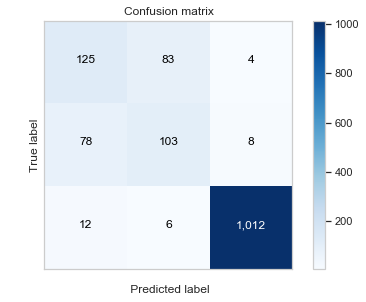

['used_tender_offer_stake_only_tactic_1', 'glass_lewis_support_Split', 'used_nominate_slate_of_directors_tactic_1', 'current_entity_detail_Mutual Fd-Closed End', 'used_take_action_by_written_consent_tactic_1', 'proxy_proposal_others', 'poison_pill_in_force_prior_to_announcement_Yes', 'current_entity_detail_others', 'used_lawsuit_tactic_1', 'governance_demand_Missing', 'campaign_objective_primary_Block_MA', 'sector_Communications', 'used_unsolicited_offer_tactic_1', 'iss_support_Split', 'used_no_or_unknown_tactic_1', 'sector_Industrial Services', 'iss_support_Management', 'sector_Missing', 'campaign_objective_primary_Generic_Objective', 'used_threaten_proxy_fight_tactic_1']
[0.43789872507247674, 0.41239317639914574, 0.381351855764459, 0.28669850281413123, 0.26870543450367657, 0.22676015655386408, 0.1296992748926726, 0.08822340670505821, 0.08645353982414206, 0.08404304869409474, -0.3195866138950414, -0.3338065215894243, -0.34407186996132444, -0.41766642414945865, -0.4300889338221739, -0.

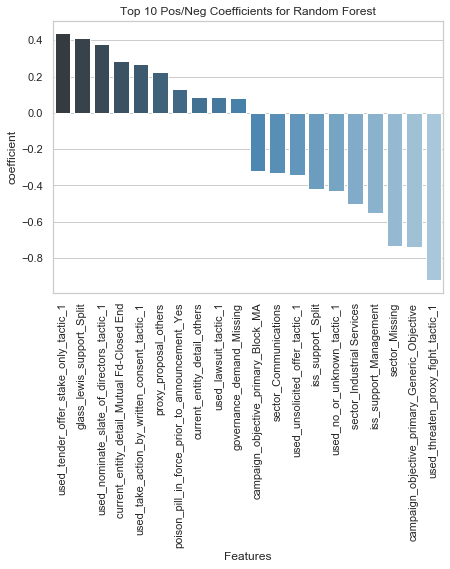

In [40]:
inference(lin_svc_best,x_train,x_test,y_test,df,'Random Forest',combine_proxy,use_coef = True, y = 'proxy_result',col = 'iss_support_Management')


The best parameter for SVM is {'C': 0.2222311111111111, 'dual': False, 'loss': 'squared_hinge', 'penalty': 'l1'}
Training mean precision for SVM is 0.64647
Testing mean precision for SVM is 0.62022


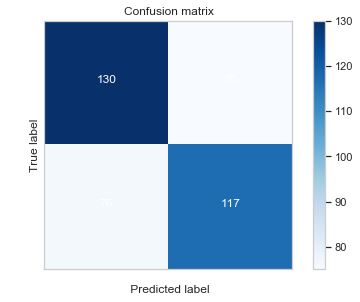

['iss_support_Management', 'iss_support_Missing', 'glass_lewis_support_Management', 'used_unsolicited_offer_tactic_1', 'iss_support_Split', 'sector_Health Services', 'proxy_proposal_others', "proxy_proposal_Elect Management's Director Nominee", 'sector_Finance', 'sector_Transportation', 'governance_demand_Operations', 'current_entity_detail_Holding Company', 'value_demand_Missing', 'poison_pill_in_force_prior_to_announcement_Yes', 'current_entity_detail_Subsidiary', 'value_demand_Operation', 'sector_Process Industries', 'sector_Consumer Non-Durables', 'current_entity_detail_Mutual Fd-Closed End', 'sector_Distribution Services']
[0.5323782525214167, 0.3833530670219207, 0.3181241471416736, 0.2433828893328505, 0.21255456763977906, 0.20646561968801172, 0.16357070431266701, 0.14471665380297818, 0.14261481286541147, 0.11425082478615922, -0.08508964716948936, -0.13550231889635972, -0.14230109554939357, -0.16002295261235394, -0.1660218751034585, -0.18278896311731416, -0.1846988706816201, -0.19

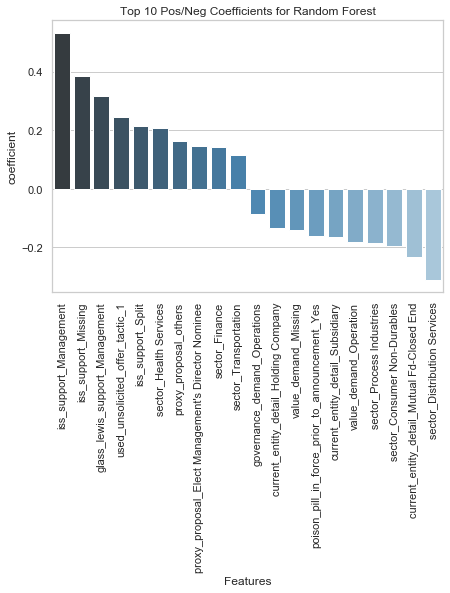

In [41]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC, LinearSVC
# svm = OneVsRestClassifier(LinearSVC())
lin_svc = svm.LinearSVC()

param_grid = {'penalty':  ['l1','l2'],
              'C': np.linspace(0.00001,2,10),
              'loss':['squared_hinge'],
              'dual':[False]}

grid = GridSearchCV(lin_svc, param_grid, cv=5, scoring = 'precision_macro')
grid.fit(x_train_complete, y_train_complete)
lin_svc_best = grid.best_estimator_
print("The best parameter for SVM is {}".format(grid.best_params_))
print("Training mean precision for SVM is {}".format(round(grid.score(x_train_complete, y_train_complete),5)))
print("Testing mean precision for SVM is {}".format(round(grid.score(x_test_complete, y_test_complete),5)))

conf, pre_recall = produce_confusion_matrix(x_test_complete, y_test_complete, 'proxy_result',lin_svc_best) 
pre_recall

inference(lin_svc_best,x_train_complete,x_test_complete,y_test_complete,df,'Random Forest',combine_proxy_complete,use_coef = True, y = 'proxy_result',col = 'iss_support_Management')


## Hard Vote

In [42]:
eclf1 = VotingClassifier(estimators=[('lg', lg_l1_complete_best), 
                                     ('lg2', lg_l2_best_complete), 
                                     ('rf', rf2),
                                    ('xgb', xgb), 
                                    ('nc', nc_best),
                                    ('svm', lin_svc_best)], 
                         voting='hard')
eclf1 = eclf1.fit(x_train_complete, y_train_complete)
y_pred1 = eclf1.predict(x_test_complete)
# print("Accuracy is %.2f%%" % ((np.sum(y_pred1 == np.array(y_test).flatten()) / len(y_pred1))*100))
print("Training precision for hard vote is {}".format(round(precision_score(y_train_complete, eclf1.predict(x_train_complete),average='macro'),5)))
print("Testing precision for hard vote is {}".format(round(precision_score(y_test_complete, eclf1.predict(x_test_complete),average='macro'),5)))

Training precision for hard vote is 0.66123
Testing precision for hard vote is 0.61028


In [43]:
conf, pre_recall = produce_confusion_matrix(x_test_complete, y_test_complete, 'proxy_result', eclf1) 
pre_recall

,Precision,Recall
Management,0.607955,0.554404
Dissident,0.612613,0.663415


## Soft Vote

In [44]:
eclf2 = VotingClassifier(estimators=[('lg', lg_l1_complete_best), 
                                     ('lg2', lg_l2_best_complete), 
                                     ('rf', rf2),
                                    ('xgb', xgb), 
#                                     ('nc', nc_best),
#                                     ('svm', lin_svc_best)
                                    ], 
                         voting='soft')
eclf2 = eclf2.fit(x_train_complete, y_train_complete)
y_pred2 = eclf2.predict(x_test_complete)
print("Training precision for soft vote is {}".format(round(precision_score(y_train_complete, eclf2.predict(x_train_complete),average='macro'),5)))
print("Testing precision for soft vote is {}".format(round(precision_score(y_test_complete, eclf2.predict(x_test_complete),average='macro'),5)))

Training precision for soft vote is 0.66053
Testing precision for soft vote is 0.62267


In [45]:
conf, pre_recall = produce_confusion_matrix(x_test_complete, y_test_complete, 'proxy_result', eclf2) 
pre_recall

,Precision,Recall
Management,0.613757,0.601036
Dissident,0.631579,0.643902


## Weights Based Weights Soft Vote

In [46]:
compute_weights = lambda pipelines,x_train,y_train,x_test,y_test: [x.fit(x_train,y_train).score(x_test,y_test) for x in pipelines]
ensemble = [lg_l1_complete_best,lg_l2_best_complete,rf2,xgb]
weights = compute_weights(ensemble,x_train_complete,y_train_complete,x_test_complete,y_test_complete)

eclf3 = VotingClassifier(estimators=[('lg', lg_l1_complete_best), 
                                     ('lg2', lg_l2_best_complete), 
                                     ('rf', rf2),
                                    ('xgb', xgb)], 
                                     voting='soft', 
                                     weights=weights,
                                     flatten_transform=True)
eclf3 = eclf3.fit(x_train_complete, y_train_complete)
y_pred3 = eclf3.predict(x_test_complete)
# print("Accuracy is %.2f%%" % ((np.sum(y_pred3 == np.array(y_test).flatten()) / len(y_pred3))*100))
print("Training precision for soft vote is {}".format(round(precision_score(y_train_complete, eclf3.predict(x_train_complete),average='macro'),5)))
print("Testing precision for soft vote is {}".format(round(precision_score(y_test_complete, eclf3.predict(x_test_complete),average='macro'),5)))

Training precision for soft vote is 0.66097
Testing precision for soft vote is 0.61763


In [47]:
conf, pre_recall = produce_confusion_matrix(x_test_complete, y_test_complete, 'proxy_result', eclf3) 
pre_recall

,Precision,Recall
Management,0.608466,0.595855
Dissident,0.626794,0.639024


# Seat_gained_success

Fail               0.580645
Success            0.258065
Partial_success    0.161290
Name: seat_gained_success, dtype: float64


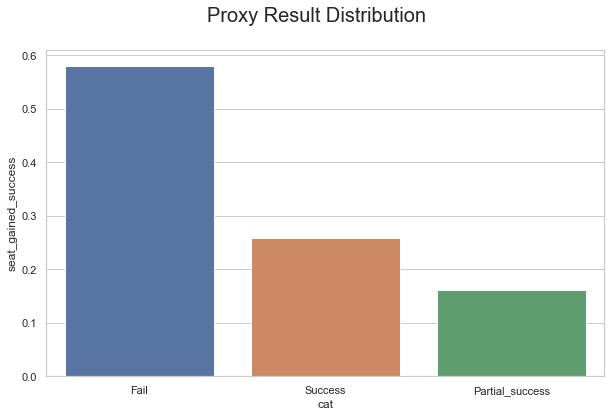

In [48]:
f, ax = plt.subplots(figsize=(10, 6))
y_dist = (y_test_seat['seat_gained_success'].value_counts()/ y_test_seat['seat_gained_success'].value_counts().sum()).to_frame()
y_dist['cat'] = y_dist.index
y_dist.reset_index(drop = True)
sns.barplot(x="cat", y="seat_gained_success",  data=y_dist,axes = ax)
f.suptitle('Proxy Result Distribution', fontsize=20)
# plt.xlabel('xlabel', fontsize=18)
# plt.ylabel('ylabel', fontsize=16)
# f.savefig('test.jpg')
print(y_test_seat['seat_gained_success'].value_counts()/ y_test_seat['seat_gained_success'].value_counts().sum())

Fail       0.580645
Success    0.419355
Name: seat_gained_success, dtype: float64


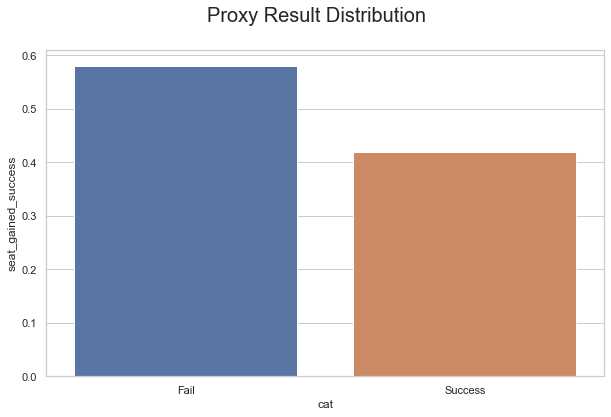

In [49]:
f, ax = plt.subplots(figsize=(10, 6))
y_dist = (y_test_seat_b['seat_gained_success'].value_counts()/ y_test_seat_b['seat_gained_success'].value_counts().sum()).to_frame()
y_dist['cat'] = y_dist.index
y_dist.reset_index(drop = True)
sns.barplot(x="cat", y="seat_gained_success",  data=y_dist,axes = ax)
f.suptitle('Proxy Result Distribution', fontsize=20)
# plt.xlabel('xlabel', fontsize=18)
# plt.ylabel('ylabel', fontsize=16)
# f.savefig('test.jpg')
print(y_test_seat_b['seat_gained_success'].value_counts()/ y_test_seat_b['seat_gained_success'].value_counts().sum())

## l1 penalty logistic regression

The best parameter for Logistic is {'C': 7.500000000000007, 'solver': 'liblinear'}
Training precision for Logistic Regression is 0.57636
Testing precision for Logistic Regression is 0.44628
                 Precision    Recall
Partial_success   0.289062  0.616667
Fail              0.680851  0.444444
Success           0.368932  0.395833


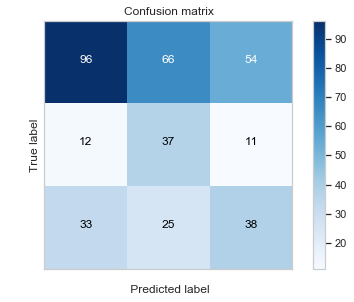

['campaign_objective_primary_Block_MA', 'iss_support_Missing', 'iss_support_Management', 'used_withhold_vote_for_directors_tactic_1', 'sector_Consumer Durables', 'used_tender_offer_stake_only_tactic_1', 'sector_Health Services', 'sector_Miscellaneous', 'iss_support_Split', 'used_nominate_slate_of_directors_tactic_1', 'current_entity_detail_others', 'used_threaten_proxy_fight_tactic_1', 'value_demand_Operation', 'governance_demand_Operations', 'value_demand_Missing', 'campaign_objective_primary_Generic_Objective', 'current_entity_detail_Mutual Fd-Closed End', 'glass_lewis_support_Missing', 'used_proxy_access_nomination_tactic_1', 'glass_lewis_support_Split']
[4.314694822461739, 1.8080224957515636, 1.749119433452586, 1.4604135257179025, 1.4040577721730756, 1.3434573912601908, 1.310941762066684, 1.2686740216475434, 1.0972726254256011, 0.9552303729532767, -0.23171327327167615, -0.2561943703133847, -0.36192716697542543, -0.37549087547059, -0.43456949937945866, -0.4828953048601297, -0.529969

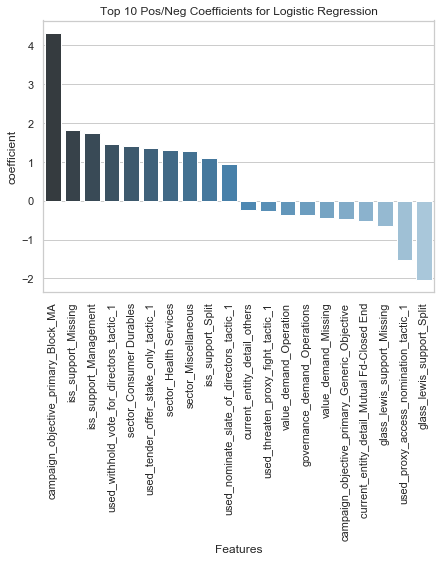

In [50]:
# Logistic regression with l1 norm
lg_l1 = LogisticRegression(penalty = 'l1',multi_class = 'auto')

# , solver = 'saga'
# Perform grid search
# param_grid = {'C': np.linspace(0.00000000000001, 2, 3)}
# param_grid = {'C': np.logspace(-4, 4, 10)}
param_grid = {'C': np.linspace(0.00000000000001, 30, 5),
             'solver': ['saga','liblinear']}
grid = GridSearchCV(lg_l1, param_grid, cv=2, scoring = 'precision_macro')
grid.fit(x_train_seat, y_train_seat)

lg_l1_best = grid.best_estimator_

print("The best parameter for Logistic is {}".format(grid.best_params_))
print("Training precision for Logistic Regression is {}".format(round(grid.score(x_train_seat, y_train_seat),5)))
print("Testing precision for Logistic Regression is {}".format(round(grid.score(x_test_seat, y_test_seat),5)))

conf, pre_recall = produce_confusion_matrix(x_test_seat, y_test_seat,'seat_gained_success',grid) 
print(pre_recall)
inference(lg_l1_best,x_train_seat,x_test_seat,y_test_seat,df,'Logistic Regression',combine_seat,use_coef = True, y = 'proxy_result',col = 'sector_Miscellaneous')


# Binary

In [51]:
# Logistic regression with l1 norm
lg_l1 = LogisticRegression(penalty = 'l1',multi_class = 'auto')

# , solver = 'saga'
# Perform grid search
# param_grid = {'C': np.linspace(0.00000000000001, 2, 3)}
# param_grid = {'C': np.logspace(-4, 4, 10)}
param_grid = {'C': np.linspace(0.00000000000001, 30, 5),
             'solver': ['saga','liblinear']}
grid = GridSearchCV(lg_l1, param_grid, cv=2, scoring = 'precision_macro')
grid.fit(x_train_seat_b, y_train_seat_b)

lg_l1_best = grid.best_estimator_

print("The best parameter for Logistic is {}".format(grid.best_params_))
print("Training precision for Logistic Regression is {}".format(round(grid.score(x_train_seat_b, y_train_seat_b),5)))
print("Testing precision for Logistic Regression is {}".format(round(grid.score(x_test_seat_b, y_test_seat_b),5)))

conf, pre_recall = produce_confusion_matrix(x_test_seat_b, y_test_seat_b,'seat_gained_success',grid) 
print(pre_recall)


The best parameter for Logistic is {'C': 7.500000000000007, 'solver': 'liblinear'}
Training precision for Logistic Regression is 0.67064
Testing precision for Logistic Regression is 0.57753
         Precision    Recall
Success   0.497297  0.589744
Fail      0.657754  0.569444


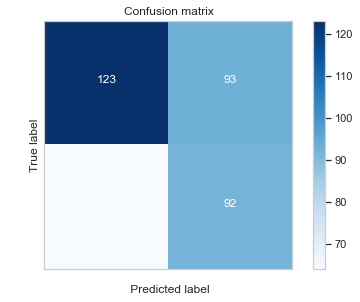

['glass_lewis_support_Split', 'used_proxy_access_nomination_tactic_1', 'current_entity_detail_Mutual Fd-Closed End', 'campaign_objective_primary_Generic_Objective', 'value_demand_Missing', 'glass_lewis_support_Missing', 'value_demand_Operation', 'governance_demand_Operations', 'poison_pill_in_force_prior_to_announcement_Yes', 'sector_Distribution Services', 'sector_Energy Minerals', 'sector_Industrial Services', 'used_withhold_vote_for_directors_tactic_1', 'iss_support_Split', 'sector_Health Services', 'sector_Miscellaneous', 'sector_Consumer Durables', 'iss_support_Missing', 'iss_support_Management', 'campaign_objective_primary_Block_MA']
[1.7306247271805513, 1.3569204690195364, 0.7360894289042819, 0.552586242161148, 0.5182986971991665, 0.4281135905670084, 0.4108919469197604, 0.3701067610394035, 0.2902690791603321, 0.18954564240309968, -0.6929560427603233, -0.89048065188658, -1.0637918930652128, -1.1704442467425997, -1.2342993674991152, -1.2528348445707311, -1.2955888745152795, -1.739

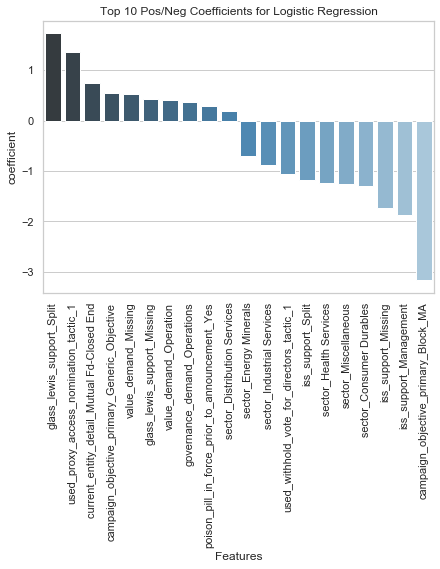

In [52]:
inference(lg_l1_best,x_train_seat_b,x_test_seat_b,y_test_seat_b,df,'Logistic Regression',combine_seat,use_coef = True, y = 'proxy_result',col = 'sector_Miscellaneous')


## l2 penalty logistic regression

In [53]:
# Logistic regression with l2 norm
lg_l2 = LogisticRegression(penalty = 'l2',multi_class = 'auto')
param_grid = {'C': np.logspace(-4, 4, 10),
             'solver': ['newton-cg', 'lbfgs', 'sag', 'saga']}
grid = GridSearchCV(lg_l2, param_grid, cv=2, scoring = 'balanced_accuracy')
grid.fit(x_train_seat, y_train_seat)
lg_l2_best = grid.best_estimator_
print("The best parameter for Logistic is {}".format(grid.best_params_))
print("Training balanced accuracy for Logistic Regression is {}".format(round(grid.score(x_train_seat, y_train_seat),5)))
print("Testing balanced accuracy for Logistic Regression is {}".format(round(grid.score(x_test_seat, y_test_seat),5)))

The best parameter for Logistic is {'C': 1291.5496650148827, 'solver': 'newton-cg'}
Training balanced accuracy for Logistic Regression is 0.58618
Testing balanced accuracy for Logistic Regression is 0.48565


In [54]:
conf, pre_recall = produce_confusion_matrix(x_test_seat, y_test_seat,'seat_gained_success',grid) 
pre_recall

,Precision,Recall
Partial_success,0.298387,0.616667
Fail,0.671329,0.444444
Success,0.361905,0.395833


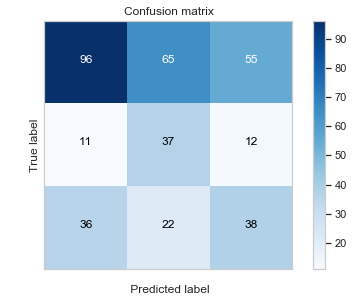

['campaign_objective_primary_Block_MA', 'sector_Miscellaneous', 'iss_support_Missing', 'iss_support_Management', 'sector_Consumer Durables', 'used_withhold_vote_for_directors_tactic_1', 'used_tender_offer_stake_only_tactic_1', 'sector_Health Services', 'iss_support_Split', 'sector_Communications', 'governance_demand_Operations', 'used_threaten_proxy_fight_tactic_1', 'value_demand_Operation', 'current_entity_detail_others', 'value_demand_Missing', 'glass_lewis_support_Missing', 'campaign_objective_primary_Generic_Objective', 'current_entity_detail_Mutual Fd-Closed End', 'used_proxy_access_nomination_tactic_1', 'glass_lewis_support_Split']
[1.7367760789799773, 1.157327439771082, 1.0762054523820144, 1.0688218886867071, 0.9800712323242499, 0.9491946488708065, 0.9317627694120343, 0.904800779499169, 0.6869450564013864, 0.6696122003754111, -0.21247438871523053, -0.23016188549023575, -0.2510085503714553, -0.28085806276661307, -0.325108736598608, -0.3329016849945272, -0.4111738002920001, -0.559

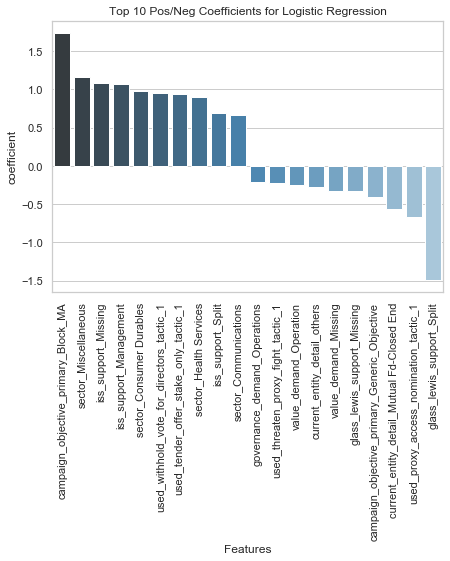

In [55]:
inference(lg_l2_best,x_train_seat,x_test_seat,y_test_seat,df,'Logistic Regression',combine_seat,use_coef = True, y = 'seat_gained_success',col = 'sector_Miscellaneous')


# Binary

The best parameter for Logistic is {'C': 21.54434690031882, 'solver': 'newton-cg'}
Training balanced accuracy for Logistic Regression is 0.67256
Testing balanced accuracy for Logistic Regression is 0.5787
         Precision    Recall
Success   0.497268  0.583333
Fail      0.656085  0.574074


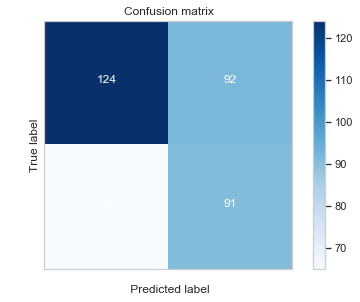

['glass_lewis_support_Split', 'used_proxy_access_nomination_tactic_1', 'current_entity_detail_Mutual Fd-Closed End', 'campaign_objective_primary_Generic_Objective', 'value_demand_Missing', 'glass_lewis_support_Missing', 'value_demand_Operation', 'governance_demand_Operations', 'poison_pill_in_force_prior_to_announcement_Yes', 'sector_Distribution Services', 'sector_Energy Minerals', 'sector_Industrial Services', 'used_withhold_vote_for_directors_tactic_1', 'iss_support_Split', 'sector_Health Services', 'sector_Miscellaneous', 'sector_Consumer Durables', 'iss_support_Missing', 'iss_support_Management', 'campaign_objective_primary_Block_MA']
[1.7921972346316108, 1.4499177034165018, 0.7515304614428288, 0.6199959290089507, 0.5227312476462983, 0.4407547146692056, 0.41628526110282155, 0.3749870347880951, 0.29213093012329056, 0.13583592246721343, -0.77954000316042, -0.9820336334111969, -1.0803632633372742, -1.2129659473719614, -1.3246017259975462, -1.3523981726702075, -1.3836590949303986, -1.

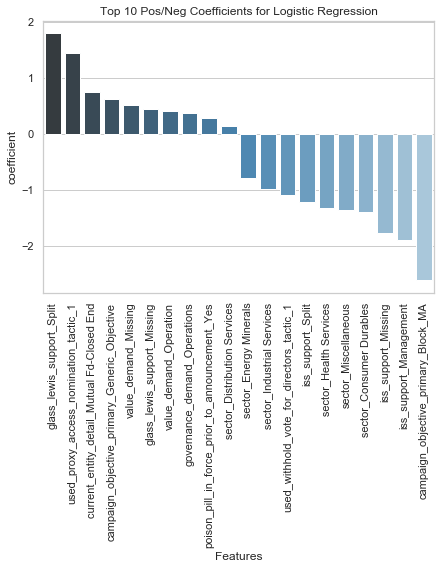

In [56]:
# Logistic regression with l2 norm
lg_l2 = LogisticRegression(penalty = 'l2',multi_class = 'auto')
param_grid = {'C': np.logspace(-4, 4, 10),
             'solver': ['newton-cg', 'lbfgs', 'sag', 'saga']}
grid = GridSearchCV(lg_l2, param_grid, cv=2, scoring = 'balanced_accuracy')
grid.fit(x_train_seat_b, y_train_seat_b)
lg_l2_best = grid.best_estimator_
print("The best parameter for Logistic is {}".format(grid.best_params_))
print("Training balanced accuracy for Logistic Regression is {}".format(round(grid.score(x_train_seat_b, y_train_seat_b),5)))
print("Testing balanced accuracy for Logistic Regression is {}".format(round(grid.score(x_test_seat_b, y_test_seat_b),5)))

conf, pre_recall = produce_confusion_matrix(x_test_seat_b, y_test_seat_b,'seat_gained_success',grid) 
print(pre_recall)

inference(lg_l2_best,x_train_seat_b,x_test_seat_b,y_test_seat_b,df,'Logistic Regression',combine_seat,use_coef = True, y = 'seat_gained_success',col = 'sector_Miscellaneous')


## Random Forest

In [57]:
# rf = RandomForestClassifier()
# param_grid = {'n_estimators': np.linspace(10, 500, 3).astype('int'),
#               'max_depth':np.linspace(10, 500, 3).astype('int'),
#               'min_samples_split':np.linspace(2, 50, 3).astype('int'),
#               'min_samples_leaf':np.linspace(1, 50, 3).astype('int'),
#               'bootstrap': [True, False],
#               'max_features': ['auto', 'sqrt'],
#              }

# grid = GridSearchCV(rf, param_grid, cv=2, scoring = 'balanced_accuracy')
# grid.fit(x_train_seat, y_train_seat)
# print("The best parameter for Logistic is {}".format(grid.best_params_))
# print("Training balanced accuracy for Random Forest is {}".format(round(grid.score(x_train_seat, y_train_seat),5)))
# print("Testing balanced accuracy for Random Forest is {}".format(round(grid.score(x_test_seat, y_test_seat),5)))

### Note:
    Since training balanced accuracy is much higher than the testing one, we think the model with best paramters from grid search is overfitting. The following model prevents overfitting.

In [58]:
rf2 = RandomForestClassifier(bootstrap = False, 
                       max_depth = 5,
                       max_features = 'auto', 
                       min_samples_leaf = 10, 
                       min_samples_split = 10,
                       n_estimators = 100)
rf2.fit(x_train_seat, y_train_seat)


RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
                       max_depth=5, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [59]:
from sklearn.metrics import balanced_accuracy_score
print("Training precision for Random Forest is {}".format(round(precision_score(y_train_seat, rf2.predict(x_train_seat),average = 'macro'),5)))
print("Testing precision accuracy for Random Forest is {}".format(round(precision_score(y_test_seat, rf2.predict(x_test_seat),average = 'macro'),5)))

Training precision for Random Forest is 0.68404
Testing precision accuracy for Random Forest is 0.42794


In [60]:
conf, pre_recall = produce_confusion_matrix(x_test_seat, y_test_seat,'seat_gained_success', rf2) 
pre_recall

,Precision,Recall
Partial_success,0.259740,0.666667
Fail,0.680000,0.393519
Success,0.344086,0.333333


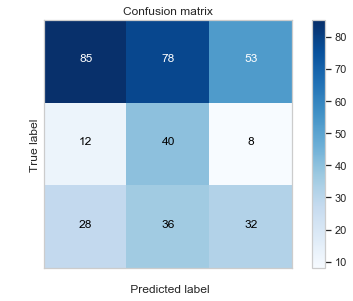

['pre_12m_earnings_yield', 'ownership_pecent_on_announcement', 'pre_3m_earnings_yield', 'price_at_announcement', 'pre_6m_earnings_yield', 'earnings_yield_at_announcement', 'pre_18m_total_return', 'iss_support_Missing', 'ltm_eps_at_announcement', 'sector_Miscellaneous']
[0.07894866198661657, 0.07780182315953994, 0.07688199300831725, 0.06681131730201767, 0.057771349884957815, 0.0506020770813443, 0.04754614794052475, 0.04287385347218372, 0.04092708715706082, 0.04088618432793009]
                                          seat_gained_success
sector_Miscellaneous seat_gained_success                     
0.0                  Partial_success                     1166
                     Success                              760
                     Fail                                 326
1.0                  Fail                                 146
                     Success                               55
                     Partial_success                        7


                     

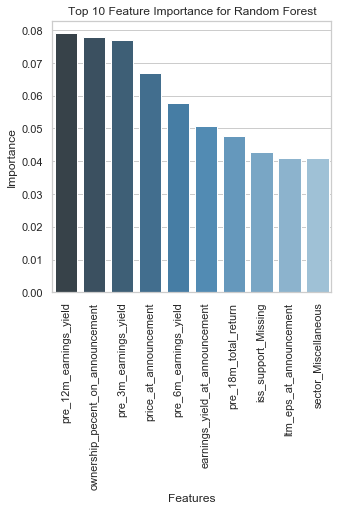

In [61]:
inference(rf2,x_train_seat,x_test_seat,y_test_seat,df,'Random Forest',combine_seat,use_coef = False, y = 'seat_gained_success',col = 'sector_Miscellaneous')


# Binary

Training precision for Random Forest is 0.75217
Testing precision accuracy for Random Forest is 0.59281
         Precision    Recall
Success   0.513661  0.602564
Fail      0.671958  0.587963


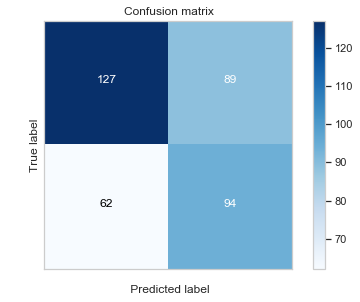

['ownership_pecent_on_announcement', 'ltm_eps_at_announcement', 'sector_Miscellaneous', 'earnings_yield_at_announcement', 'pre_12m_earnings_yield', 'price_at_announcement', 'pre_6m_earnings_yield', 'pre_18m_earnings_yield', 'pre_12m_residual_return', 'pre_18m_residual_return']
[0.10172363433474249, 0.07361697387792553, 0.06980311825703328, 0.0692751969370556, 0.06138687733732804, 0.05677794212081944, 0.0461965480103895, 0.04439260224895613, 0.042067627768271575, 0.04153416571685861]
                                          seat_gained_success
sector_Miscellaneous seat_gained_success                     
0.0                  Success                              943
                     Fail                                 528
1.0                  Fail                                 161
                     Success                                8


                                          seat_gained_success
sector_Miscellaneous seat_gained_success                     
0             

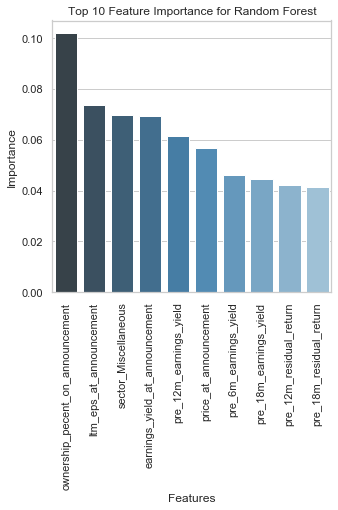

In [62]:
rf2 = RandomForestClassifier(bootstrap = False, 
                       max_depth = 5,
                       max_features = 'auto', 
                       min_samples_leaf = 10, 
                       min_samples_split = 10,
                       n_estimators = 100)
rf2.fit(x_train_seat_b, y_train_seat_b)
from sklearn.metrics import balanced_accuracy_score
print("Training precision for Random Forest is {}".format(round(precision_score(y_train_seat_b, rf2.predict(x_train_seat_b),average = 'macro'),5)))
print("Testing precision accuracy for Random Forest is {}".format(round(precision_score(y_test_seat_b, rf2.predict(x_test_seat_b),average = 'macro'),5)))


conf, pre_recall = produce_confusion_matrix(x_test_seat_b, y_test_seat_b,'seat_gained_success', rf2) 
print(pre_recall)

inference(rf2,x_train_seat_b,x_test_seat_b,y_test_seat_b,df,'Random Forest',combine_seat,use_coef = False, y = 'seat_gained_success',col = 'sector_Miscellaneous')


# Multi-layer Perceptron classifier

In [63]:
from sklearn.neural_network import MLPClassifier

In [64]:
MLP = MLPClassifier(early_stopping = True)
param_grid = {'hidden_layer_sizes': [(256,128,64),(256,128)],
              'alpha': np.linspace(0,2,5)}
grid = GridSearchCV(MLP, param_grid = param_grid, cv = 5, scoring = 'precision_macro')
grid.fit(x_train_seat, y_train_seat)
MLP_best = grid.best_estimator_
print("The best parameter for Nerual Netis {}".format(grid.best_params_))
print("Training mean precision for Nerual Net is {}".format(round(grid.score(x_train_seat, y_train_seat),5)))
print("Testing mean precision for Nerual Net is {}".format(round(grid.score(x_test_seat, y_test_seat),5)))

The best parameter for Nerual Netis {'alpha': 1.0, 'hidden_layer_sizes': (256, 128)}
Training mean precision for Nerual Net is 0.55403
Testing mean precision for Nerual Net is 0.40895


In [65]:
conf, pre_recall = produce_confusion_matrix(x_test_seat, y_test_seat,'seat_gained_success', grid) 
pre_recall

,Precision,Recall
Partial_success,0.225434,0.650000
Fail,0.653595,0.462963
Success,0.347826,0.166667


# Binary

In [66]:
MLP = MLPClassifier(early_stopping = True)
param_grid = {'hidden_layer_sizes': [(256,128,64),(256,128)],
              'alpha': np.linspace(0,2,5)}
grid = GridSearchCV(MLP, param_grid = param_grid, cv = 5, scoring = 'precision_macro')
grid.fit(x_train_seat_b, y_train_seat_b)
MLP_best = grid.best_estimator_
print("The best parameter for Nerual Netis {}".format(grid.best_params_))
print("Training mean precision for Nerual Net is {}".format(round(grid.score(x_train_seat_b, y_train_seat_b),5)))
print("Testing mean precision for Nerual Net is {}".format(round(grid.score(x_test_seat_b, y_test_seat_b),5)))


conf, pre_recall = produce_confusion_matrix(x_test_seat_b, y_test_seat_b,'seat_gained_success', grid) 
pre_recall



The best parameter for Nerual Netis {'alpha': 2.0, 'hidden_layer_sizes': (256, 128, 64)}
Training mean precision for Nerual Net is 0.6112
Testing mean precision for Nerual Net is 0.53958


,Precision,Recall
Success,0.449782,0.660256
Fail,0.629371,0.416667


# Classifier using Ridge regression

In [67]:
from sklearn.linear_model import RidgeClassifier

In [68]:
Ridge = RidgeClassifier()
param_grid = {'alpha':  np.linspace(0, 2, 20)}

grid = GridSearchCV(Ridge, param_grid, cv=5, scoring = 'precision_macro')
grid.fit(x_train_seat, y_train_seat)
ridge_best = grid.best_estimator_
print("The best parameter for Ridge Discriminant Analysis is {}".format(grid.best_params_))
print("Training mean precision for Ridge is {}".format(round(grid.score(x_train_seat, y_train_seat),5)))
print("Testing mean precision for Ridge is {}".format(round(grid.score(x_test_seat, y_test_seat),5)))

The best parameter for Ridge Discriminant Analysis is {'alpha': 1.894736842105263}
Training mean precision for Ridge is 0.57717
Testing mean precision for Ridge is 0.45397


In [69]:
conf, pre_recall = produce_confusion_matrix(x_test_seat, y_test_seat,'seat_gained_success', grid) 
pre_recall

,Precision,Recall
Partial_success,0.282443,0.616667
Fail,0.698529,0.439815
Success,0.380952,0.416667


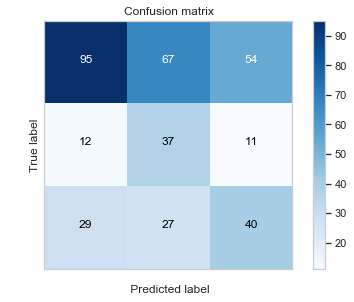

['campaign_objective_primary_Block_MA', 'iss_support_Missing', 'iss_support_Management', 'used_withhold_vote_for_directors_tactic_1', 'sector_Consumer Durables', 'sector_Health Services', 'sector_Miscellaneous', 'used_nominate_slate_of_directors_tactic_1', 'iss_support_Split', 'used_tender_offer_stake_only_tactic_1', 'current_entity_detail_Subsidiary', 'used_threaten_proxy_fight_tactic_1', 'campaign_objective_primary_Generic_Objective', 'governance_demand_Operations', 'value_demand_Operation', 'value_demand_Missing', 'current_entity_detail_Mutual Fd-Closed End', 'glass_lewis_support_Missing', 'used_proxy_access_nomination_tactic_1', 'glass_lewis_support_Split']
[0.7668606592821786, 0.6270111291392388, 0.6122778190561945, 0.5294533473778921, 0.525868987509099, 0.5048135708796967, 0.5010445220681655, 0.3212774667289642, 0.31981078487952364, 0.3194265463185871, -0.08169377653757891, -0.09327514712859458, -0.13036435351450842, -0.13425021224734432, -0.1612845219884807, -0.18936733737251496

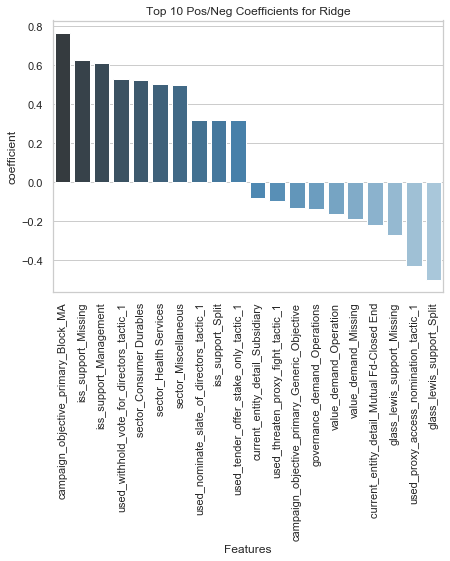

In [70]:
inference(ridge_best,x_train_seat,x_test_seat,y_test_seat,df,'Ridge',combine_seat,use_coef = True, y = 'seat_gained_success',col = 'sector_Miscellaneous')


# Binary

The best parameter for Ridge Discriminant Analysis is {'alpha': 0.631578947368421}
Training mean precision for Ridge is 0.67206
Testing mean precision for Ridge is 0.59508
         Precision    Recall
Success   0.516484  0.602564
Fail      0.673684  0.592593


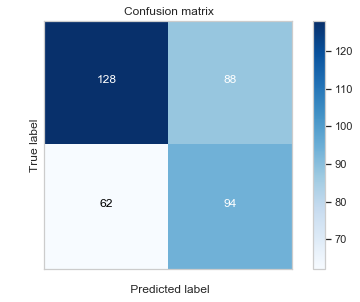

['glass_lewis_support_Split', 'used_proxy_access_nomination_tactic_1', 'campaign_objective_primary_Generic_Objective', 'value_demand_Missing', 'current_entity_detail_Mutual Fd-Closed End', 'value_demand_Operation', 'glass_lewis_support_Missing', 'governance_demand_Operations', 'poison_pill_in_force_prior_to_announcement_Yes', 'current_entity_detail_Public', 'sector_Energy Minerals', 'sector_Industrial Services', 'used_withhold_vote_for_directors_tactic_1', 'iss_support_Split', 'sector_Miscellaneous', 'sector_Health Services', 'sector_Consumer Durables', 'iss_support_Missing', 'iss_support_Management', 'campaign_objective_primary_Block_MA']
[0.5749594254649414, 0.5253771502902246, 0.2446846008840589, 0.21896299334410568, 0.19756180062200382, 0.1883669277816666, 0.16496969413507895, 0.1470673865975645, 0.1164570718147606, 0.05634264297251737, -0.32823376238938856, -0.406777864263978, -0.41162950465199794, -0.4404493227209517, -0.45784407300694624, -0.5572017699355235, -0.5760720561810998

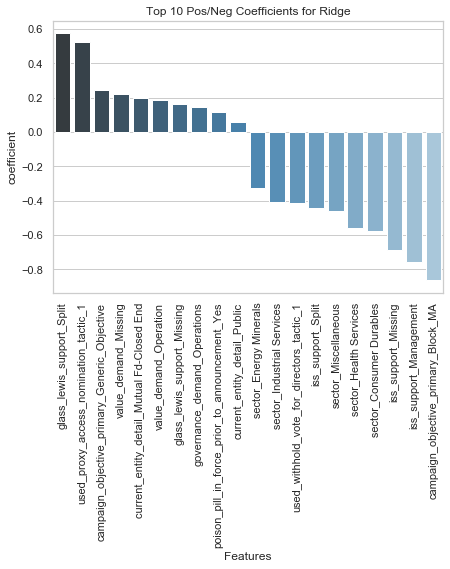

In [71]:
Ridge = RidgeClassifier()
param_grid = {'alpha':  np.linspace(0, 2, 20)}

grid = GridSearchCV(Ridge, param_grid, cv=5, scoring = 'precision_macro')
grid.fit(x_train_seat_b, y_train_seat_b)
ridge_best = grid.best_estimator_
print("The best parameter for Ridge Discriminant Analysis is {}".format(grid.best_params_))
print("Training mean precision for Ridge is {}".format(round(grid.score(x_train_seat_b, y_train_seat_b),5)))
print("Testing mean precision for Ridge is {}".format(round(grid.score(x_test_seat_b, y_test_seat_b),5)))

conf, pre_recall = produce_confusion_matrix(x_test_seat_b, y_test_seat_b,'seat_gained_success', grid) 
print(pre_recall)

inference(ridge_best,x_train_seat_b,x_test_seat_b,y_test_seat_b,df,'Ridge',combine_seat,use_coef = True, y = 'seat_gained_success',col = 'sector_Miscellaneous')


## Xgboost

In [72]:
xgb = XGBClassifier()
param_grid = {'n_estimators':[500]}
grid = GridSearchCV(xgb, param_grid, cv=5, scoring = 'precision_macro')
grid.fit(x_train_seat, y_train_seat)
xgb_best = grid.best_estimator_
# print("The best parameter for xgboost is {}".format(grid.best_params_))
print("Training accuracy for xgboost is {}".format(round(grid.score(x_train_seat, y_train_seat),5)))
print("Testing accuracy for xgboost is {}".format(round(grid.score(x_test_seat, y_test_seat),5)))


The best parameter for xgboost is {'n_estimators': 500}
Training accuracy for xgboost is 0.97399
Testing accuracy for xgboost is 0.46156


In [73]:
conf, pre_recall = produce_confusion_matrix(x_test_seat, y_test_seat,'seat_gained_success', grid) 
pre_recall

,Precision,Recall
Partial_success,0.375000,0.500000
Fail,0.660287,0.638889
Success,0.349398,0.302083


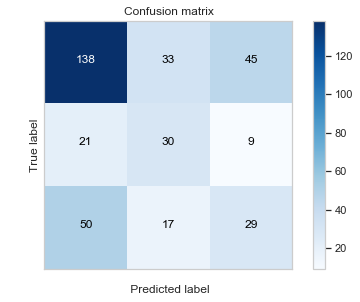

['sector_Miscellaneous', 'value_demand_Missing', 'iss_support_Missing', 'iss_support_Management', 'sector_Finance', 'pre_12m_earnings_yield', 'sector_Retail Trade', 'used_hostile_offer_tactic_1', 'current_entity_detail_Mutual Fd-Closed End', 'proxy_proposal_others']
[0.046552435, 0.040329825, 0.038312145, 0.0290667, 0.02601727, 0.025145566, 0.021191688, 0.020901186, 0.01989766, 0.019530725]


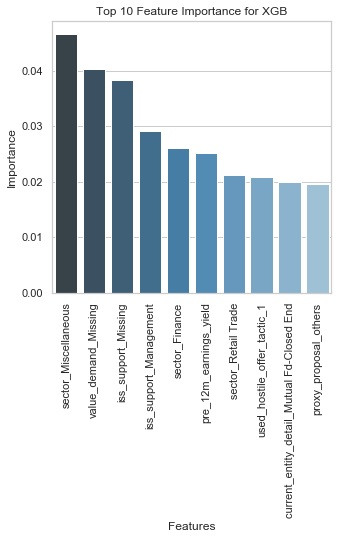

In [76]:
inference(xgb_best,x_train_seat,x_test_seat,y_test_seat,df,'XGB',combine_seat,use_coef = False, y = 'seat_gained_success',col = 'sector_Miscellaneous',dir_inference = False)


# Binary

The best parameter for xgboost is {'n_estimators': 500}
Training accuracy for xgboost is 0.96286
Testing accuracy for xgboost is 0.5534
         Precision    Recall
Success   0.478788  0.506410
Fail      0.628019  0.601852


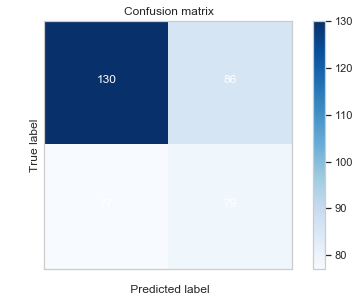

['sector_Miscellaneous', 'used_hostile_offer_tactic_1', 'iss_support_Missing', 'used_unsolicited_offer_tactic_1', 'iss_support_Management', 'glass_lewis_support_Missing', 'sector_Energy Minerals', 'used_propose_precatory_proposal_tactic_1', 'sector_Consumer Services', 'value_demand_Missing']
[0.13035803, 0.05553041, 0.03805833, 0.034603525, 0.03382614, 0.03237158, 0.023653878, 0.021155944, 0.020540206, 0.020243173]


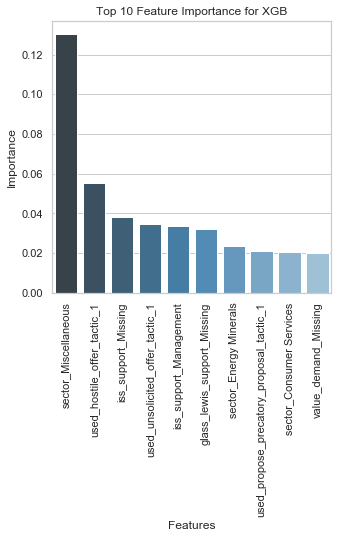

In [77]:
xgb = XGBClassifier()
param_grid = {'n_estimators':[500]}
grid = GridSearchCV(xgb, param_grid, cv=5, scoring = 'precision_macro')
grid.fit(x_train_seat_b, y_train_seat_b)
xgb_best = grid.best_estimator_
print("The best parameter for xgboost is {}".format(grid.best_params_))
print("Training accuracy for xgboost is {}".format(round(grid.score(x_train_seat_b, y_train_seat_b),5)))
print("Testing accuracy for xgboost is {}".format(round(grid.score(x_test_seat_b, y_test_seat_b),5)))

conf, pre_recall = produce_confusion_matrix(x_test_seat_b, y_test_seat_b,'seat_gained_success', grid) 
print(pre_recall)


inference(xgb_best,x_train_seat_b,x_test_seat_b,y_test_seat_b,df,'XGB',combine_seat,use_coef = False, y = 'seat_gained_success',col = 'sector_Miscellaneous',dir_inference = False)


## Nearest Centroid

In [78]:
nc = NearestCentroid()
param_grid = {'metric':['euclidean','manhattan']}
grid = GridSearchCV(nc, param_grid, cv=5)
grid.fit(x_train_seat, y_train_seat)
nc_best = grid.best_estimator_

print("The best parameter for Nearest Centroid is {}".format(grid.best_params_))
print("Training accuracy for Nearest Centroid is {}".format(round(grid.score(x_train_seat, y_train_seat),5)))
print("Testing accuracy for Nearest Centroid is {}".format(round(grid.score(x_test_seat, y_test_seat),5)))

The best parameter for Nearest Centroid is {'metric': 'euclidean'}
Training accuracy for Nearest Centroid is 0.44715
Testing accuracy for Nearest Centroid is 0.3172


In [79]:
conf, pre_recall = produce_confusion_matrix(x_test_seat, y_test_seat,'seat_gained_success',grid) 
pre_recall

,Precision,Recall
Partial_success,0.191111,0.716667
Fail,0.596330,0.300926
Success,0.263158,0.104167


# Binary 

In [80]:
nc = NearestCentroid()
param_grid = {'metric':['euclidean','manhattan']}
grid = GridSearchCV(nc, param_grid, cv=5)
grid.fit(x_train_seat_b, y_train_seat_b)
nc_best = grid.best_estimator_

print("The best parameter for Nearest Centroid is {}".format(grid.best_params_))
print("Training accuracy for Nearest Centroid is {}".format(round(grid.score(x_train_seat_b, y_train_seat_b),5)))
print("Testing accuracy for Nearest Centroid is {}".format(round(grid.score(x_test_seat_b, y_test_seat_b),5)))

conf, pre_recall = produce_confusion_matrix(x_test_seat_b, y_test_seat_b,'seat_gained_success',grid) 
pre_recall

The best parameter for Nearest Centroid is {'metric': 'euclidean'}
Training accuracy for Nearest Centroid is 0.57073
Testing accuracy for Nearest Centroid is 0.49194


,Precision,Recall
Success,0.429185,0.641026
Fail,0.597122,0.384259


## Support Vector Matchine

In [81]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC, LinearSVC
# svm = OneVsRestClassifier(LinearSVC())
lin_svc = svm.LinearSVC()

param_grid = {'penalty':  ['l1','l2'],
              'C': np.linspace(0.00001,2,5),
              'loss':['squared_hinge'],
              'dual':[False]}

grid = GridSearchCV(lin_svc, param_grid, cv=5, scoring = 'precision_macro')
grid.fit(x_train_seat, y_train_seat)
lin_svc_best = grid.best_estimator_
print("The best parameter for SVM is {}".format(grid.best_params_))
print("Training mean precision for SVM is {}".format(round(grid.score(x_train_seat, y_train_seat),5)))
print("Testing mean precision for SVM is {}".format(round(grid.score(x_test_seat, y_test_seat),5)))

The best parameter for SVM is {'C': 1.000005, 'dual': False, 'loss': 'squared_hinge', 'penalty': 'l1'}
Training mean precision for SVM is 0.57935
Testing mean precision for SVM is 0.45225


In [82]:
conf, pre_recall = produce_confusion_matrix(x_test_seat, y_test_seat,'seat_gained_success', grid) 

In [83]:
pre_recall

,Precision,Recall
Partial_success,0.282443,0.616667
Fail,0.695652,0.444444
Success,0.378641,0.406250


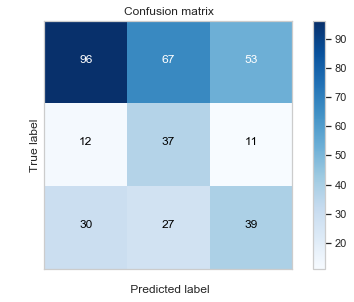

['campaign_objective_primary_Block_MA', 'iss_support_Missing', 'iss_support_Management', 'used_withhold_vote_for_directors_tactic_1', 'sector_Consumer Durables', 'sector_Health Services', 'sector_Miscellaneous', 'used_tender_offer_stake_only_tactic_1', 'iss_support_Split', 'used_nominate_slate_of_directors_tactic_1', 'current_entity_detail_Subsidiary', 'used_threaten_proxy_fight_tactic_1', 'campaign_objective_primary_Generic_Objective', 'governance_demand_Operations', 'value_demand_Operation', 'value_demand_Missing', 'current_entity_detail_Mutual Fd-Closed End', 'glass_lewis_support_Missing', 'used_proxy_access_nomination_tactic_1', 'glass_lewis_support_Split']
[1.3677787642791475, 0.6471859728600482, 0.6364254493058509, 0.5757434905360475, 0.5527879616620954, 0.5277557634463412, 0.5128546813864281, 0.4795100450647172, 0.3729393402134179, 0.3367093449523181, -0.08466416672989048, -0.08554725818468639, -0.09165553790451766, -0.14235033184768067, -0.15815067706448885, -0.1893412247199861

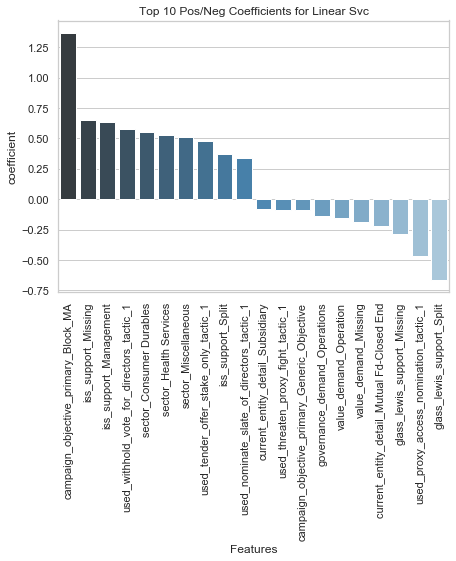

In [84]:
inference(lin_svc_best,x_train_seat,x_test_seat,y_test_seat,df,'Linear Svc',combine_seat,use_coef = True, y = 'seat_gained_success',col = 'sector_Miscellaneous')


# Binary

The best parameter for SVM is {'C': 0.5000074999999999, 'dual': False, 'loss': 'squared_hinge', 'penalty': 'l1'}
Training mean precision for SVM is 0.66929
Testing mean precision for SVM is 0.58743
         Precision    Recall
Success   0.508197  0.596154
Fail      0.666667  0.583333


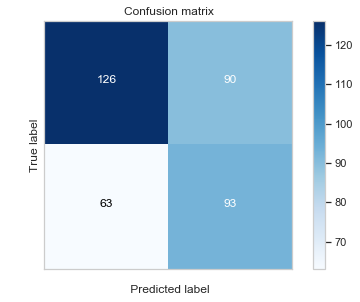

['glass_lewis_support_Split', 'used_proxy_access_nomination_tactic_1', 'value_demand_Missing', 'current_entity_detail_Mutual Fd-Closed End', 'value_demand_Operation', 'campaign_objective_primary_Generic_Objective', 'governance_demand_Operations', 'glass_lewis_support_Missing', 'poison_pill_in_force_prior_to_announcement_Yes', 'current_entity_detail_Public', 'sector_Energy Minerals', 'sector_Industrial Services', 'iss_support_Split', 'sector_Miscellaneous', 'used_withhold_vote_for_directors_tactic_1', 'sector_Health Services', 'sector_Consumer Durables', 'campaign_objective_primary_Block_MA', 'iss_support_Missing', 'iss_support_Management']
[0.5354862286579835, 0.36344756343060197, 0.22374204185356866, 0.20487474106501063, 0.18479518509801482, 0.17018979010773408, 0.15069828499549293, 0.1439907183233609, 0.11927398356360361, 0.07523598378766383, -0.2642213628814922, -0.3255212658710281, -0.38731511827387166, -0.38944079389628633, -0.4221096142389883, -0.47950630745047246, -0.50384666933

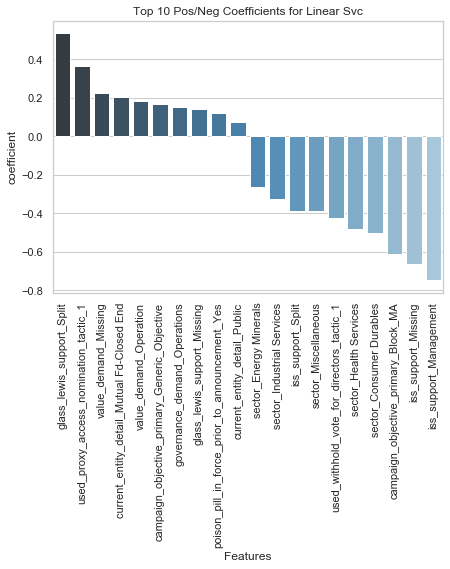

In [85]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC, LinearSVC
# svm = OneVsRestClassifier(LinearSVC())
lin_svc = svm.LinearSVC()

param_grid = {'penalty':  ['l1','l2'],
              'C': np.linspace(0.00001,2,5),
              'loss':['squared_hinge'],
              'dual':[False]}

grid = GridSearchCV(lin_svc, param_grid, cv=5, scoring = 'precision_macro')
grid.fit(x_train_seat_b, y_train_seat_b)
lin_svc_best = grid.best_estimator_
print("The best parameter for SVM is {}".format(grid.best_params_))
print("Training mean precision for SVM is {}".format(round(grid.score(x_train_seat_b, y_train_seat_b),5)))
print("Testing mean precision for SVM is {}".format(round(grid.score(x_test_seat_b, y_test_seat_b),5)))

conf, pre_recall = produce_confusion_matrix(x_test_seat_b, y_test_seat_b,'seat_gained_success', grid) 
print(pre_recall)

inference(lin_svc_best,x_train_seat_b,x_test_seat_b,y_test_seat_b,df,'Linear Svc',combine_seat,use_coef = True, y = 'seat_gained_success',col = 'sector_Miscellaneous')


# Ada boost

In [86]:
from sklearn.ensemble import AdaBoostClassifier

ada = AdaBoostClassifier()
param_grid = {'n_estimators':  np.linspace(200,400,5).astype('int')}

grid = GridSearchCV(ada, param_grid, cv=5, scoring = 'precision_macro')
grid.fit(x_train_seat, y_train_seat)
ada_best = grid.best_estimator_
print("The best parameter for Adapative Boosting is {}".format(grid.best_params_))
print("Training mean precision for Adapative Boosting is {}".format(round(grid.score(x_train_seat, y_train_seat),5)))
print("Testing mean precision for Adapative Boosting is {}".format(round(grid.score(x_test_seat, y_test_seat),5)))

The best parameter for Adapative Boosting is {'n_estimators': 300}
Training mean precision for Adapative Boosting is 0.68074
Testing mean precision for Adapative Boosting is 0.43029


In [87]:
conf, pre_recall = produce_confusion_matrix(x_test_seat, y_test_seat,'seat_gained_success', grid) 
pre_recall

,Precision,Recall
Partial_success,0.237113,0.383333
Fail,0.664865,0.569444
Success,0.388889,0.364583


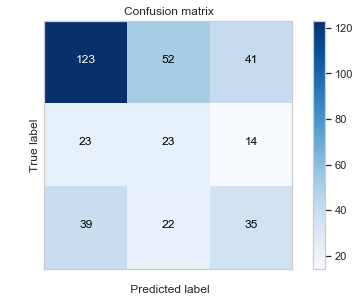

['price_at_announcement', 'pre_6m_residual_return', 'pre_12m_residual_return', 'earnings_yield_at_announcement', 'pre_18m_residual_return', 'pre_12m_earnings_yield', 'ownership_pecent_on_announcement', 'pre_18m_earnings_yield', 'pre_3m_earnings_yield', 'pre_18m_total_return']
[0.12, 0.1, 0.07666666666666666, 0.07, 0.07, 0.06333333333333334, 0.06, 0.056666666666666664, 0.05333333333333334, 0.05]
                                          seat_gained_success
sector_Miscellaneous seat_gained_success                     
0.0                  Partial_success                      872
                     Success                              786
                     Fail                                 594
1.0                  Fail                                 161
                     Success                               46
                     Partial_success                        1


                                          seat_gained_success
sector_Miscellaneous seat_gained_success  

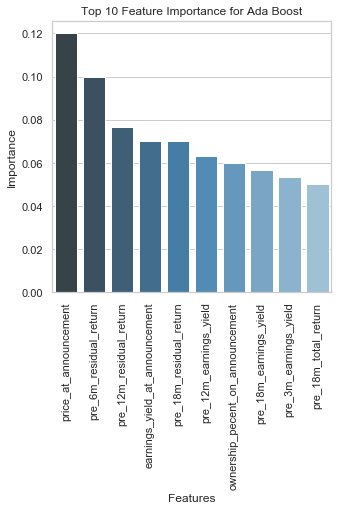

In [88]:
inference(ada_best,x_train_seat,x_test_seat,y_test_seat,df,'Ada Boost',combine_seat,use_coef = False, y = 'seat_gained_success',col = 'sector_Miscellaneous')


# Binary

The best parameter for Adapative Boosting is {'n_estimators': 400}
Training mean precision for Adapative Boosting is 0.82029
Testing mean precision for Adapative Boosting is 0.56392
         Precision    Recall
Success   0.493590  0.493590
Fail      0.634259  0.634259


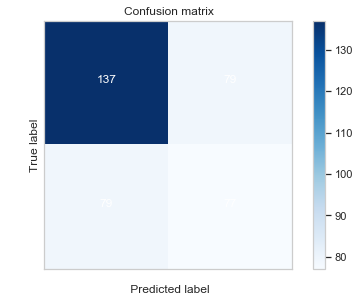

['pre_12m_residual_return', 'pre_18m_residual_return', 'ownership_pecent_on_announcement', 'pre_6m_residual_return', 'pre_12m_earnings_yield', 'price_at_announcement', 'pre_18m_total_return', 'pre_3m_earnings_yield', 'earnings_yield_at_announcement', 'pre_18m_earnings_yield']
[0.1, 0.0975, 0.0925, 0.0775, 0.075, 0.07, 0.0625, 0.06, 0.0575, 0.0575]
                                          seat_gained_success
sector_Miscellaneous seat_gained_success                     
0.0                  Success                              820
                     Fail                                 651
1.0                  Fail                                 150
                     Success                               19


                                          seat_gained_success
sector_Miscellaneous seat_gained_success                     
0                    Success                              874
                     Fail                                 766


                          

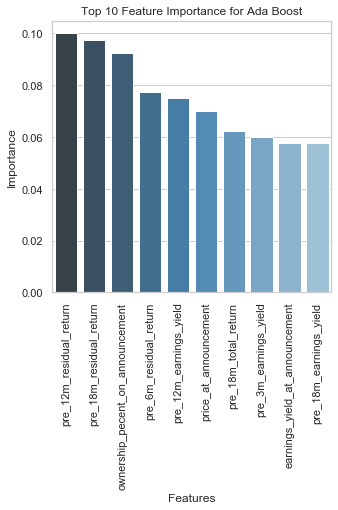

In [89]:
from sklearn.ensemble import AdaBoostClassifier

ada = AdaBoostClassifier()
param_grid = {'n_estimators':  np.linspace(200,400,5).astype('int')}

grid = GridSearchCV(ada, param_grid, cv=5, scoring = 'precision_macro')
grid.fit(x_train_seat_b, y_train_seat_b)
ada_best = grid.best_estimator_
print("The best parameter for Adapative Boosting is {}".format(grid.best_params_))
print("Training mean precision for Adapative Boosting is {}".format(round(grid.score(x_train_seat_b, y_train_seat_b),5)))
print("Testing mean precision for Adapative Boosting is {}".format(round(grid.score(x_test_seat_b, y_test_seat_b),5)))

conf, pre_recall = produce_confusion_matrix(x_test_seat_b, y_test_seat_b,'seat_gained_success', grid) 
print(pre_recall)

inference(ada_best,x_train_seat_b,x_test_seat_b,y_test_seat_b,df,'Ada Boost',combine_seat,use_coef = False, y = 'seat_gained_success',col = 'sector_Miscellaneous')


## Hard Vote

In [90]:
eclf = VotingClassifier(estimators=[('lg', lg_l1_best), 
                                     ('lg2', lg_l2_best), 
                                     ('rf', rf2),
                                     ('xgb', xgb),
                                     ('MLP',MLP_best),
                                     ('ridge',ridge_best),
                                     ('svm',lin_svc_best),
                                     ('ada',ada_best),
                                     ('nc',nc_best)], 
                                     voting='hard')
eclf = eclf.fit(x_train_seat_b, y_train_seat_b)
y_pred = eclf.predict(x_test_seat_b)
# print("Accuracy is %.2f%%" % ((np.sum(y_pred == np.array(y_test_seat).flatten()) / len(y_pred))*100))

In [91]:
conf, pre_recall = produce_confusion_matrix(x_test_seat_b, y_test_seat_b,'seat_gained_success',eclf) 
pre_recall

,Precision,Recall
Success,0.484211,0.589744
Fail,0.648352,0.546296


## Soft Vote

In [92]:
eclf2 = VotingClassifier(estimators=[('lg', lg_l1_best), 
                                     ('lg2', lg_l2_best), 
                                     ('rf', rf2),
                                     ('xgb', xgb),
                                     ('MLP',MLP_best),
                                     ('ada',ada_best)], 
                                     voting='soft')
eclf2 = eclf2.fit(x_train_seat_b, y_train_seat_b)
y_pred2 = eclf2.predict(x_test_seat_b)
# print("Accuracy is %.2f%%" % ((np.sum(y_pred3 == np.array(y_test_seat).flatten()) / len(y_pred3))*100))

In [93]:
conf, pre_recall = produce_confusion_matrix(x_test_seat_b, y_test_seat_b,'seat_gained_success',eclf2) 
pre_recall

,Precision,Recall
Success,0.505495,0.589744
Fail,0.663158,0.583333


## Weights Based Weights Soft Vote

In [94]:
compute_weights = lambda pipelines,x_train_seat,y_train_seat,x_test_seat,y_test_seat: [x.fit(x_train_seat,y_train_seat).score(x_test_seat,y_test_seat) for x in pipelines]
ensemble = [lg_l1_best,lg_l2_best,rf2,xgb,MLP_best,ada_best]
weights = compute_weights(ensemble,x_train_seat_b,y_train_seat_b,x_test_seat_b,y_test_seat_b)

eclf3 = VotingClassifier(estimators=[('lg', lg_l1_best), 
                                     ('lg2', lg_l2_best), 
                                     ('rf', rf2),
                                     ('xgb', xgb),
                                     ('MLP',MLP_best),
                                     ('ada',ada_best)], 
                                     voting='soft', 
                                     weights=weights,
                                     flatten_transform=True)
eclf3 = eclf3.fit(x_train_seat_b, y_train_seat_b)
y_pred3 = eclf3.predict(x_test_seat_b)
print("Accuracy is %.2f%%" % ((np.sum(y_pred3 == np.array(y_test_seat).flatten()) / len(y_pred3))*100))

Accuracy is 45.97%


In [95]:
conf, pre_recall = produce_confusion_matrix(x_test_seat_b, y_test_seat_b,'seat_gained_success',eclf3) 
pre_recall

,Precision,Recall
Success,0.484694,0.608974
Fail,0.653409,0.532407
